<a href="https://www.kaggle.com/code/ravaghi/cibmtr-equity-in-post-hct-survival-ridge?scriptVersionId=226039124" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports and configs

In [1]:
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter
from sklearn.preprocessing import quantile_transform
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.base import clone
from autogluon.tabular import TabularPredictor
from scipy.stats import rankdata 
from numba import jit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import optuna
import joblib
import shutil
import json
import gc
import os

warnings.filterwarnings("ignore")

In [2]:
class CFG:
    train_path = "/kaggle/input/equity-post-HCT-survival-predictions/train.csv"
    test_path = "/kaggle/input/equity-post-HCT-survival-predictions/test.csv"
    sample_sub_path = "/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv"

    n_folds = 10
    seed = 42

    run_feature_selection = False

    run_optuna = False
    optuna_trials = 250
    optuna_warmup_trials = optuna_trials // 10

In [3]:
# Reference: https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/discussion/555029

@jit(nopython=True)
def init_BTree(values):
    times_to_compare = np.empty_like(values)
    last_full_row = int(np.log2(len(values) + 1) - 1)
    len_ragged_row = len(values) - (2 ** (last_full_row + 1) - 1)
    if len_ragged_row > 0:
        bottom_row_ix = slice(None, 2 * len_ragged_row, 2)
        times_to_compare[-len_ragged_row:] = values[bottom_row_ix]
        values = np.delete(values, bottom_row_ix)
    values_start = 0
    values_space = 2
    values_len = 2 ** last_full_row
    while values_start < len(values):
        times_to_compare[values_len - 1: 2 * values_len - 1] = values[values_start::values_space]
        values_start += int(values_space / 2)
        values_space *= 2
        values_len = int(values_len / 2)
    return times_to_compare


@jit(nopython=True)
def insert(counts, pred, times_to_compare):
    i = 0
    n = len(times_to_compare)
    while (i < n):
        cur = times_to_compare[i]
        counts[i] += 1
        if pred < cur:
            i = 2 * i + 1
        elif pred > cur:
            i = 2 * i + 2
        else:
            return counts


@jit(nopython=True)
def fn_rank(pred, times_to_compare, counts):
    i = 0
    n = len(times_to_compare)
    rank = 0
    count = 0
    while (i < n):
        cur = times_to_compare[i]
        if pred < cur:
            i = 2 * i + 1
            continue
        elif pred > cur:
            rank += counts[i]
            nexti = 2 * i + 2
            if nexti < n:
                rank -= counts[nexti]
                i = nexti
                continue
            else:
                return rank, count
        else:
            count = counts[i]
            lefti = 2 * i + 1
            if lefti < n:
                nleft = counts[lefti]
                count -= nleft
                rank += nleft
                righti = lefti + 1
                if righti < n:
                    count -= counts[righti]
            return rank, count
    return rank, count


@jit(nopython=True)
def handle_pairs(truth, pred, first_ix, times_to_compare, counts):
    next_ix = first_ix
    while next_ix < len(truth) and truth[next_ix] == truth[first_ix]:
        next_ix += 1
    pairs = counts[0] * (next_ix - first_ix)
    correct = np.int64(0)
    tied = np.int64(0)
    for i in range(first_ix, next_ix):
        rank, count = fn_rank(pred[i], times_to_compare, counts)
        correct += rank
        tied += count
    return (pairs, correct, tied, next_ix)


@jit(nopython=True)
def fast_concordance_index(event_times, predicted_event_times, event_observed):
    died_mask = event_observed == 1
    died_truth = event_times[died_mask]
    ix = np.argsort(died_truth)
    died_truth = died_truth[ix]
    died_pred = predicted_event_times[died_mask][ix]

    censored_truth = event_times[~died_mask]
    ix = np.argsort(censored_truth)
    censored_truth = censored_truth[ix]
    censored_pred = predicted_event_times[~died_mask][ix]

    censored_ix = 0
    died_ix = 0

    times_to_compare = init_BTree(np.unique(died_pred))
    counts = np.full(len(times_to_compare), 0)

    num_pairs = np.int64(0)
    num_correct = np.int64(0)
    num_tied = np.int64(0)

    while True:
        has_more_censored = censored_ix < len(censored_truth)
        has_more_died = died_ix < len(died_truth)
        if has_more_censored and (not has_more_died or died_truth[died_ix] > censored_truth[censored_ix]):
            pairs, correct, tied, next_ix = handle_pairs(censored_truth, censored_pred, censored_ix, times_to_compare, counts)
            censored_ix = next_ix

        elif has_more_died and (not has_more_censored or died_truth[died_ix] <= censored_truth[censored_ix]):
            pairs, correct, tied, next_ix = handle_pairs(died_truth, died_pred, died_ix, times_to_compare, counts)
            for pred in died_pred[died_ix:next_ix]:
                insert(counts, pred, times_to_compare)
            died_ix = next_ix
        else:
            assert not (has_more_died or has_more_censored)
            break

        num_pairs += pairs
        num_correct += correct
        num_tied += tied

    return (num_correct + num_tied / 2) / num_pairs


def score_f(y_true, y_pred, return_details=False):
    races = [
        "More than one race", "Asian", "White", "American Indian or Alaska Native",
        "Native Hawaiian or other Pacific Islander", "Black or African-American"
    ]

    metric_list = []
    for race in races:
        mask = y_true.race_group.values == race
        if isinstance(y_pred, pd.Series):
            c_index_race = fast_concordance_index(y_true.efs_time[mask].values, -y_pred[mask].values.ravel(), y_true.efs[mask].values)
        else:
            c_index_race = fast_concordance_index(y_true.efs_time[mask].values, -y_pred[mask].ravel(), y_true.efs[mask].values)
        metric_list.append(c_index_race)

    if return_details:
        return np.mean(metric_list) - np.std(metric_list), np.mean(metric_list), np.std(metric_list)
    else:
        return np.mean(metric_list) - np.std(metric_list)

# Common functions

In [4]:
scores = {}
overall_scores = {}

oof_preds = {}
test_preds = {}

## Target transformations

In [5]:
class TargetTransformer:
    def __init__(self, y_train, y_test):
        self.y_train = y_train
        self.y_test = y_test
        
    def create_cox_target(self):
        # https://www.kaggle.com/code/andreasbis/cibmtr-eda-ensemble-model
        
        y_train = pd.DataFrame({"efs_time": self.y_train.efs_time, "efs": self.y_train.efs, "time": self.y_train.efs_time, "event": self.y_train.efs})
        y_test = pd.DataFrame({"efs_time": self.y_test.efs_time, "efs": self.y_test.efs, "time": self.y_test.efs_time, "event": self.y_test.efs})
        
        cph = CoxPHFitter()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            cph.fit(y_train, duration_col="time", event_col="event")
            
        y_train = cph.predict_partial_hazard(y_train)
        y_test = cph.predict_partial_hazard(y_test)

        return y_train, y_test
    
    def create_kaplan_meier_target(self):
        kmf = KaplanMeierFitter()
        kmf.fit(durations=self.y_train.efs_time, event_observed=self.y_train.efs)
        
        y_train = kmf.survival_function_at_times(self.y_train.efs_time).values
        y_test = kmf.survival_function_at_times(self.y_test.efs_time).values

        return y_train, y_test
    
    def create_nelson_aalen_target(self):
        naf = NelsonAalenFitter()
        naf.fit(durations=self.y_train.efs_time, event_observed=self.y_train.efs)
        
        y_train = naf.cumulative_hazard_at_times(self.y_train.efs_time).values * -1
        y_test = naf.cumulative_hazard_at_times(self.y_test.efs_time).values * -1

        return y_train, y_test
    
    def create_cox_loss_target(self, time, event):
        return np.where(event == 1, time, -time)
    
    def create_separate_target(self, time, event):
        # https://www.kaggle.com/code/mtinti/cibmtr-lofo-feature-importance-gpu-accelerated
        transformed = time.values.copy()
        mx = transformed[event == 1].max() # last patient who dies
        mn = transformed[event == 0].min() # first patient who survives
        transformed[event == 0] = time[event == 0] + mx - mn
        transformed = rankdata(transformed)
        transformed[event == 0] += len(transformed) // 2
        transformed = transformed / transformed.max()
        return - transformed
    
    def create_rank_log_target(self, time, event):
        # https://www.kaggle.com/code/ambrosm/esp-eda-which-makes-sense
        transformed = time.values.copy()
        mx = transformed[event == 1].max() # last patient who dies
        mn = transformed[event == 0].min() # first patient who survives
        transformed[event == 0] = time[event == 0] + mx - mn
        transformed = rankdata(transformed)
        transformed[event == 0] += len(transformed) * 2
        transformed = transformed / transformed.max()
        transformed = np.log(transformed)
        return - transformed
    
    def create_quantile_target(self, time, event):
        # https://www.kaggle.com/code/ambrosm/esp-eda-which-makes-sense
        transformed = np.full(len(time), np.nan)
        transformed_dead = quantile_transform(- time[event == 1].values.reshape(-1, 1), random_state=CFG.seed).ravel()
        transformed[event == 1] = transformed_dead
        transformed[event == 0] = transformed_dead.min() - 0.3
        return transformed

    def create_exponential_rank_target(self, time, event):
        transformed = time.values.copy()
        death_times = transformed[event == 1]
        transformed[event == 1] = np.exp(rankdata(death_times) / len(death_times))
        max_death = transformed[event == 1].max()
        transformed[event == 0] = max_death + 0.2
        transformed = (transformed - transformed.min()) / (transformed.max() - transformed.min())
        return -transformed

    def fit_transform(self, target_name):
        target_transformers_1 = {
            "cox": self.create_cox_target,
            "kaplan_meier": self.create_kaplan_meier_target,
            "nelson_aalen": self.create_nelson_aalen_target
        }

        target_transformers_2 = {
            "cox_loss": self.create_cox_loss_target,
            "separate": self.create_separate_target,
            "rank_log": self.create_rank_log_target,
            "quantile": self.create_quantile_target,
            "exponential_rank": self.create_exponential_rank_target,
        }

        if target_name in target_transformers_1.keys():
            return target_transformers_1[target_name]()

        else:
            y_train_time = self.y_train.efs_time
            y_train_event = self.y_train.efs

            y_test_time = self.y_test.efs_time
            y_test_event = self.y_test.efs

            y_train = target_transformers_2[target_name](y_train_time, y_train_event)
            y_test = target_transformers_2[target_name](y_test_time, y_test_event)

            return y_train, y_test

## Trainer

In [6]:
class Trainer:
    def __init__(self, pipeline, target_transformation, pipeline_name, config):
        self.pipeline = pipeline
        self.target_transformation = target_transformation
        self.pipeline_name = pipeline_name
        self.config = config
        
    def fit(self, X, y):     
        model_name = self.pipeline.steps[-1][0]
        print(f"Training {model_name} with target transformation: {self.target_transformation}\n")
        
        X = X.drop(columns=["ID"])
                
        scores = []
        oof_preds = np.zeros(X.shape[0])
        pipelines = []
        
        split = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            y_train, y_val = TargetTransformer(y_train, y_val).fit_transform(self.target_transformation)
            
            model = clone(self.pipeline)
            model.fit(X_train, y_train)
            
            y_preds = model.predict(X_val)
            oof_preds[val_idx] = y_preds
            
            y_true_fold = pd.DataFrame({
                "efs": y["efs"].iloc[val_idx], 
                "efs_time": y["efs_time"].iloc[val_idx],
                "race_group": X["race_group"].iloc[val_idx]
            })
            
            fold_score = score_f(y_true_fold, y_preds)
            scores.append(fold_score)
        
            print(f"--- Fold {fold_idx + 1} - CI: {fold_score:.6f}")
            
            pipelines.append(model)
        
            del X_train, y_train, X_val, y_val, y_preds
            gc.collect() 
        
        y_true = pd.DataFrame({
            "efs": y["efs"],
            "efs_time": y["efs_time"],
            "race_group": X["race_group"]
        })
        
        overall_score = score_f(y_true.copy(), oof_preds)
        
        print(f"\n------ Overall CI: {overall_score:.6f}\n")
        
        os.makedirs(self.pipeline_name, exist_ok=True)
        joblib.dump(pipelines, f"{self.pipeline_name}/{self.pipeline_name}_pipeline.pkl")
        joblib.dump(oof_preds, f"{self.pipeline_name}/{self.pipeline_name}_oof_preds.pkl")
    
    def predict(self, X, y, X_test, oof_path):             
        print(f"Running inference on {self.pipeline_name}\n")
        
        X = X.drop(columns=["ID"])
        X_test = X_test.drop(columns=["ID"])
                
        scores = []
        oof_preds = joblib.load(f"{oof_path}/{self.pipeline_name}/{self.pipeline_name}_oof_preds.pkl")
        test_preds = np.zeros(X_test.shape[0])
        
        split = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True).split(X, y)
        for fold_idx, (_, val_idx) in enumerate(split):            
            model = self.pipeline[fold_idx]
            
            y_preds = oof_preds[val_idx]
            temp_test_preds = model.predict(X_test)
            test_preds += temp_test_preds / self.config.n_folds
                        
            y_true_fold = pd.DataFrame({
                "efs": y["efs"].iloc[val_idx], 
                "efs_time": y["efs_time"].iloc[val_idx],
                "race_group": X["race_group"].iloc[val_idx]
            })
            
            fold_score = score_f(y_true_fold, y_preds)
            scores.append(fold_score)
        
            print(f"--- Fold {fold_idx + 1} - CI: {fold_score:.6f}")
        
            del y_preds, temp_test_preds
            gc.collect() 
        
        y_true = pd.DataFrame({
            "efs": y["efs"],
            "efs_time": y["efs_time"],
            "race_group": X["race_group"]
        })
        
        overall_score = score_f(y_true.copy(), oof_preds)
        
        print(f"\n------ Overall CI: {overall_score:.6f}\n")

        return oof_preds, test_preds, scores, overall_score
    
    def tune(self, X, y):             
        X = X.drop(columns=["ID"])
                
        scores = []
        oof_preds = np.zeros(X.shape[0])
        
        split = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            y_train, y_val = TargetTransformer(y_train, y_val).fit_transform(self.target_transformation)
            
            model = clone(self.pipeline)
            model.fit(X_train, y_train)
            
            y_preds = model.predict(X_val)
            oof_preds[val_idx] = y_preds
            
            y_true_fold = pd.DataFrame({
                "efs": y["efs"].iloc[val_idx], 
                "efs_time": y["efs_time"].iloc[val_idx],
                "race_group": X["race_group"].iloc[val_idx]
            })
            
            fold_score = score_f(y_true_fold, y_preds)
            scores.append(fold_score)
        
            del X_train, y_train, X_val, y_val, y_preds
            gc.collect() 
        
        y_true = pd.DataFrame({
            "efs": y["efs"],
            "efs_time": y["efs_time"],
            "race_group": X["race_group"]
        })
        
        return score_f(y_true.copy(), oof_preds)

# Mahdi

In [7]:
oof_path = "/kaggle/input/cibmtr-pretrained-models"

## Loading data

In [8]:
train = pd.read_csv(CFG.train_path)
test = pd.read_csv(CFG.test_path)

X = train.drop(columns=["efs", "efs_time"])
y = train[["efs", "efs_time"]]

X_test = test

## Preprocessing pipelines

In [9]:
class DataImputer(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_fill=-1, categorical_fill="missing"):
        self.numeric_fill = numeric_fill
        self.categorical_fill = categorical_fill
        self.numeric_cols = None
        self.categorical_cols = None
        
    def fit(self, X, y=None):
        self.numeric_cols = X.select_dtypes(include="number").columns.tolist()
        self.categorical_cols = X.select_dtypes(exclude="number").columns.tolist()
        return self
    
    def transform(self, X):
        X = X.copy()
        # Fill numeric columns
        for col in self.numeric_cols:
            if col in X.columns:
                X[col] = X[col].fillna(self.numeric_fill)
        
        # Fill categorical columns
        for col in self.categorical_cols:
            if col in X.columns:
                X[col] = X[col].fillna(self.categorical_fill)
        
        return X

In [10]:
class TypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.numeric_cols = None
        self.categorical_cols = None
        
    def fit(self, X, y=None):
        self.numeric_cols = X.select_dtypes(include="number").columns.tolist()
        self.categorical_cols = X.select_dtypes(exclude="number").columns.tolist()
        return self
    
    def transform(self, X):
        X = X.copy()
        # Convert numeric columns to float32
        for col in self.numeric_cols:
            if col in X.columns:
                X[col] = X[col].astype("float32")
        
        # Convert categorical columns to category
        for col in self.categorical_cols:
            if col in X.columns:
                X[col] = X[col].astype("category")
        
        # Special handling for ID column
        if "ID" in X.columns:
            X["ID"] = X["ID"].astype("int32")
            
        return X

## Running inference

### XGBoost

In [11]:
xgb_non_fe_target_transformations = [
    "cox", 
    "kaplan_meier",
    "nelson_aalen", 
    "cox_loss",
    "separate", 
    "rank_log", 
    "quantile",
    "exponential_rank"
]

In [12]:
for tt in xgb_non_fe_target_transformations:
    pipeline_path = f"{oof_path}/xgb_{tt}/xgb_{tt}_pipeline.pkl"
    pipeline = joblib.load(pipeline_path)
    trainer = Trainer(pipeline, tt, f"xgb_{tt}", CFG)
    oof_preds[f"xgb_{tt}"], test_preds[f"xgb_{tt}"], scores[f"xgb_{tt}"], overall_scores[f"xgb_{tt}"] = trainer.predict(X, y, X_test, oof_path)
    
    del pipeline, trainer
    gc.collect()

Running inference on xgb_cox

--- Fold 1 - CI: 0.669964
--- Fold 2 - CI: 0.677471
--- Fold 3 - CI: 0.672383
--- Fold 4 - CI: 0.666294
--- Fold 5 - CI: 0.666148
--- Fold 6 - CI: 0.672831
--- Fold 7 - CI: 0.657993
--- Fold 8 - CI: 0.656999
--- Fold 9 - CI: 0.658537
--- Fold 10 - CI: 0.661802

------ Overall CI: 0.673831

Running inference on xgb_kaplan_meier

--- Fold 1 - CI: 0.672145
--- Fold 2 - CI: 0.673227
--- Fold 3 - CI: 0.677482
--- Fold 4 - CI: 0.667692
--- Fold 5 - CI: 0.662809
--- Fold 6 - CI: 0.669484
--- Fold 7 - CI: 0.660601
--- Fold 8 - CI: 0.650845
--- Fold 9 - CI: 0.654345
--- Fold 10 - CI: 0.664638

------ Overall CI: 0.673709

Running inference on xgb_nelson_aalen

--- Fold 1 - CI: 0.669893
--- Fold 2 - CI: 0.677630
--- Fold 3 - CI: 0.680322
--- Fold 4 - CI: 0.670331
--- Fold 5 - CI: 0.666939
--- Fold 6 - CI: 0.673766
--- Fold 7 - CI: 0.659752
--- Fold 8 - CI: 0.658839
--- Fold 9 - CI: 0.659126
--- Fold 10 - CI: 0.668435

------ Overall CI: 0.676224

Running inference o

### LightGBM

In [13]:
lgb_non_fe_target_transformations = [
    "cox", 
    "kaplan_meier",
    "nelson_aalen", 
    "separate", 
    "rank_log", 
    "quantile",
    "exponential_rank"
]

In [14]:
for tt in lgb_non_fe_target_transformations:
    pipeline_path = f"{oof_path}/lgb_{tt}/lgb_{tt}_pipeline.pkl"
    pipeline = joblib.load(pipeline_path)
    trainer = Trainer(pipeline, tt, f"lgb_{tt}", CFG)
    oof_preds[f"lgb_{tt}"], test_preds[f"lgb_{tt}"], scores[f"lgb_{tt}"], overall_scores[f"lgb_{tt}"] = trainer.predict(X, y, X_test, oof_path)
    
    del pipeline, trainer
    gc.collect()

Running inference on lgb_cox

--- Fold 1 - CI: 0.669339
--- Fold 2 - CI: 0.670989
--- Fold 3 - CI: 0.673373
--- Fold 4 - CI: 0.666864
--- Fold 5 - CI: 0.666920
--- Fold 6 - CI: 0.669988
--- Fold 7 - CI: 0.660164
--- Fold 8 - CI: 0.653186
--- Fold 9 - CI: 0.656501
--- Fold 10 - CI: 0.663232

------ Overall CI: 0.673491

Running inference on lgb_kaplan_meier

--- Fold 1 - CI: 0.669328
--- Fold 2 - CI: 0.671668
--- Fold 3 - CI: 0.678461
--- Fold 4 - CI: 0.668064
--- Fold 5 - CI: 0.663629
--- Fold 6 - CI: 0.669977
--- Fold 7 - CI: 0.660123
--- Fold 8 - CI: 0.653511
--- Fold 9 - CI: 0.657027
--- Fold 10 - CI: 0.666593

------ Overall CI: 0.674549

Running inference on lgb_nelson_aalen

--- Fold 1 - CI: 0.672471
--- Fold 2 - CI: 0.675547
--- Fold 3 - CI: 0.680074
--- Fold 4 - CI: 0.671099
--- Fold 5 - CI: 0.668284
--- Fold 6 - CI: 0.671942
--- Fold 7 - CI: 0.661545
--- Fold 8 - CI: 0.657285
--- Fold 9 - CI: 0.657801
--- Fold 10 - CI: 0.670821

------ Overall CI: 0.677004

Running inference o

### LightGBM (goss)

In [15]:
lgb_goss_non_fe_target_transformations = [
    "cox", 
    "kaplan_meier",
    "nelson_aalen", 
    "rank_log", 
    "quantile",
    "exponential_rank"
]

In [16]:
for tt in lgb_goss_non_fe_target_transformations:
    pipeline_path = f"{oof_path}/lgb_goss_{tt}/lgb_goss_{tt}_pipeline.pkl"
    pipeline = joblib.load(pipeline_path)
    trainer = Trainer(pipeline, tt, f"lgb_goss_{tt}", CFG)
    oof_preds[f"lgb_goss_{tt}"], test_preds[f"lgb_goss_{tt}"], scores[f"lgb_goss_{tt}"], overall_scores[f"lgb_goss_{tt}"] = trainer.predict(X, y, X_test, oof_path)
    
    del pipeline, trainer
    gc.collect()

Running inference on lgb_goss_cox

--- Fold 1 - CI: 0.668544
--- Fold 2 - CI: 0.673314
--- Fold 3 - CI: 0.672487
--- Fold 4 - CI: 0.667926
--- Fold 5 - CI: 0.662882
--- Fold 6 - CI: 0.668798
--- Fold 7 - CI: 0.657377
--- Fold 8 - CI: 0.652824
--- Fold 9 - CI: 0.652571
--- Fold 10 - CI: 0.665273

------ Overall CI: 0.671789

Running inference on lgb_goss_kaplan_meier

--- Fold 1 - CI: 0.664582
--- Fold 2 - CI: 0.671410
--- Fold 3 - CI: 0.674665
--- Fold 4 - CI: 0.669896
--- Fold 5 - CI: 0.664835
--- Fold 6 - CI: 0.669078
--- Fold 7 - CI: 0.657703
--- Fold 8 - CI: 0.652516
--- Fold 9 - CI: 0.654285
--- Fold 10 - CI: 0.663097

------ Overall CI: 0.673088

Running inference on lgb_goss_nelson_aalen

--- Fold 1 - CI: 0.666852
--- Fold 2 - CI: 0.674707
--- Fold 3 - CI: 0.677315
--- Fold 4 - CI: 0.670632
--- Fold 5 - CI: 0.664848
--- Fold 6 - CI: 0.668593
--- Fold 7 - CI: 0.659050
--- Fold 8 - CI: 0.654537
--- Fold 9 - CI: 0.655017
--- Fold 10 - CI: 0.666003

------ Overall CI: 0.673961

Runn

### CatBoost

In [17]:
cb_non_fe_target_transformations = [
    "cox", 
    "kaplan_meier",
    "nelson_aalen", 
    "cox_loss",
    "separate", 
    "rank_log", 
    "quantile",
    "exponential_rank"
]

In [18]:
for tt in cb_non_fe_target_transformations:
    pipeline_path = f"{oof_path}/cb_{tt}/cb_{tt}_pipeline.pkl"
    pipeline = joblib.load(pipeline_path)
    trainer = Trainer(pipeline, tt, f"cb_{tt}", CFG)
    oof_preds[f"cb_{tt}"], test_preds[f"cb_{tt}"], scores[f"cb_{tt}"], overall_scores[f"cb_{tt}"] = trainer.predict(X, y, X_test, oof_path)
    
    del pipeline, trainer
    gc.collect()

Running inference on cb_cox

--- Fold 1 - CI: 0.669958
--- Fold 2 - CI: 0.668065
--- Fold 3 - CI: 0.674203
--- Fold 4 - CI: 0.671200
--- Fold 5 - CI: 0.667932
--- Fold 6 - CI: 0.671969
--- Fold 7 - CI: 0.667635
--- Fold 8 - CI: 0.650461
--- Fold 9 - CI: 0.653914
--- Fold 10 - CI: 0.663030

------ Overall CI: 0.674260

Running inference on cb_kaplan_meier

--- Fold 1 - CI: 0.670457
--- Fold 2 - CI: 0.672149
--- Fold 3 - CI: 0.679234
--- Fold 4 - CI: 0.672191
--- Fold 5 - CI: 0.668052
--- Fold 6 - CI: 0.670621
--- Fold 7 - CI: 0.668015
--- Fold 8 - CI: 0.655872
--- Fold 9 - CI: 0.654253
--- Fold 10 - CI: 0.665811

------ Overall CI: 0.675466

Running inference on cb_nelson_aalen

--- Fold 1 - CI: 0.671064
--- Fold 2 - CI: 0.672719
--- Fold 3 - CI: 0.683174
--- Fold 4 - CI: 0.676019
--- Fold 5 - CI: 0.671299
--- Fold 6 - CI: 0.673392
--- Fold 7 - CI: 0.669542
--- Fold 8 - CI: 0.658155
--- Fold 9 - CI: 0.660885
--- Fold 10 - CI: 0.669447

------ Overall CI: 0.678191

Running inference on c

### HistGB

In [19]:
histgb_non_fe_target_transformations = [
    "cox", 
    "kaplan_meier",
    "nelson_aalen", 
    "separate", 
    "rank_log", 
    "quantile",
    "exponential_rank"
]

In [20]:
for tt in histgb_non_fe_target_transformations:
    pipeline_path = f"{oof_path}/histgb_{tt}/histgb_{tt}_pipeline.pkl"
    pipeline = joblib.load(pipeline_path)
    trainer = Trainer(pipeline, tt, f"histgb_{tt}", CFG)
    oof_preds[f"histgb_{tt}"], test_preds[f"histgb_{tt}"], scores[f"histgb_{tt}"], overall_scores[f"histgb_{tt}"] = trainer.predict(X, y, X_test, oof_path)
    
    del pipeline, trainer
    gc.collect()

Running inference on histgb_cox

--- Fold 1 - CI: 0.667249
--- Fold 2 - CI: 0.671091
--- Fold 3 - CI: 0.673343
--- Fold 4 - CI: 0.662242
--- Fold 5 - CI: 0.660077
--- Fold 6 - CI: 0.669701
--- Fold 7 - CI: 0.659834
--- Fold 8 - CI: 0.656790
--- Fold 9 - CI: 0.654962
--- Fold 10 - CI: 0.662023

------ Overall CI: 0.671170

Running inference on histgb_kaplan_meier

--- Fold 1 - CI: 0.667796
--- Fold 2 - CI: 0.675001
--- Fold 3 - CI: 0.673699
--- Fold 4 - CI: 0.664922
--- Fold 5 - CI: 0.661993
--- Fold 6 - CI: 0.670339
--- Fold 7 - CI: 0.658598
--- Fold 8 - CI: 0.658403
--- Fold 9 - CI: 0.655763
--- Fold 10 - CI: 0.662812

------ Overall CI: 0.672459

Running inference on histgb_nelson_aalen

--- Fold 1 - CI: 0.670529
--- Fold 2 - CI: 0.676589
--- Fold 3 - CI: 0.676570
--- Fold 4 - CI: 0.668086
--- Fold 5 - CI: 0.664743
--- Fold 6 - CI: 0.671975
--- Fold 7 - CI: 0.660866
--- Fold 8 - CI: 0.659825
--- Fold 9 - CI: 0.658112
--- Fold 10 - CI: 0.666892

------ Overall CI: 0.674734

Running in

### AutoGluon

In [21]:
def get_autogluon_results(predictor_path, target_transformation, oof_path):
    print(f"Running inference on autogluon with target transformation: {target_transformation}\n")
    
    # Load OOF file
    temp_oof_preds = joblib.load(oof_path)
    
    # Run inference
    temp_test = pd.read_csv(CFG.test_path)
    temp_test = temp_test.drop(["ID"], axis=1)  

    if len(temp_test) > 3:
        predictor = TabularPredictor.load(predictor_path)
        temp_test_preds = predictor.predict(temp_test).values
    else:
        predictor = None
        temp_test_preds = np.array([0, 0, 0])
    
    # Calculate overall score
    temp_train = pd.read_csv(CFG.train_path)  
    y_true = temp_train[["efs", "efs_time", "race_group"]].copy()
    temp_overall_score = score_f(y_true, temp_oof_preds)
    
    # Get fold scores
    temp_scores = []
    kf = KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    for fold_idx, (_, val_index) in enumerate(kf.split(temp_train, temp_train[["efs", "efs_time"]])):
        y_true_fold = temp_train.iloc[val_index][["efs", "efs_time", "race_group"]].copy()
        
        fold_score = score_f(y_true_fold, temp_oof_preds[val_index])        
        temp_scores.append(fold_score)

        print(f"--- Fold {fold_idx + 1} - CI: {fold_score:.6f}")

    print(f"\n------ Overall CI: {temp_overall_score:.6f}\n")

    del predictor, temp_train, temp_test
    gc.collect()

    return temp_oof_preds, temp_test_preds, temp_scores, temp_overall_score

In [22]:
ag_non_fe_target_transformations = [
    "cox", 
    "kaplan_meier",
    "nelson_aalen", 
    "rank_log", 
    "quantile",
    "exponential_rank"
]

In [23]:
for tt in ag_non_fe_target_transformations:
    ag_res = get_autogluon_results(
        predictor_path=f"{oof_path}/ag_{tt}/ag_{tt}",
        target_transformation=tt,
        oof_path=f"{oof_path}/ag_{tt}/ag_{tt}_oof_preds.pkl",
    )
    
    oof_preds[f"ag_{tt}"], test_preds[f"ag_{tt}"], scores[f"ag_{tt}"], overall_scores[f"ag_{tt}"] = ag_res

Running inference on autogluon with target transformation: cox

--- Fold 1 - CI: 0.675470
--- Fold 2 - CI: 0.675858
--- Fold 3 - CI: 0.674999
--- Fold 4 - CI: 0.674770
--- Fold 5 - CI: 0.669851
--- Fold 6 - CI: 0.675070
--- Fold 7 - CI: 0.667914
--- Fold 8 - CI: 0.662285
--- Fold 9 - CI: 0.661586
--- Fold 10 - CI: 0.669106

------ Overall CI: 0.678582

Running inference on autogluon with target transformation: kaplan_meier

--- Fold 1 - CI: 0.673170
--- Fold 2 - CI: 0.675962
--- Fold 3 - CI: 0.678723
--- Fold 4 - CI: 0.674072
--- Fold 5 - CI: 0.669339
--- Fold 6 - CI: 0.674986
--- Fold 7 - CI: 0.668371
--- Fold 8 - CI: 0.661483
--- Fold 9 - CI: 0.661445
--- Fold 10 - CI: 0.665958

------ Overall CI: 0.678119

Running inference on autogluon with target transformation: nelson_aalen

--- Fold 1 - CI: 0.675304
--- Fold 2 - CI: 0.677277
--- Fold 3 - CI: 0.681723
--- Fold 4 - CI: 0.675308
--- Fold 5 - CI: 0.673257
--- Fold 6 - CI: 0.678634
--- Fold 7 - CI: 0.668621
--- Fold 8 - CI: 0.661922


### Neural networks

In [24]:
import os
import joblib
import torch
from sklearn.model_selection import KFold
from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar, StochasticWeightAveraging
from pytorch_lightning.utilities import grad_norm
from pytorch_tabular.models.common.layers import ODST
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from torch.utils.data import TensorDataset
from lifelines.utils import concordance_index
from typing import List
from torch import nn
import pytorch_lightning as pl
import torch
import functools
from torch.utils.data import TensorDataset

pl.seed_everything(42)

def add_nn_features(df):
    # Original features
    df["age_karnofsky"] = df["age_at_hct"] * df["karnofsky_score"]
    df["age_comorbidity"] = df["age_at_hct"] * df["comorbidity_score"]
    df["donor_recipient_age_diff"] = abs(df["donor_age"] - df["age_at_hct"])
    df["years_since_2000"] = df["year_hct"] - 2000
    df["hla_match_ratio"] = (df["hla_high_res_8"] + df["hla_low_res_8"]) / 16
    df["age_squared"] = df["age_at_hct"] ** 2
    df["karnofsky_squared"] = df["karnofsky_score"] ** 2
    
    # HLA matching features
    hla_high_cols = ["hla_match_a_high", "hla_match_b_high", "hla_match_c_high", 
                     "hla_match_drb1_high", "hla_match_dqb1_high"]
    df["high_res_match_score"] = df[hla_high_cols].mean(axis=1)
    
    # Age-related risk factors
    df["age_risk"] = df["age_at_hct"].apply(lambda x: 1 if x > 60 else 0)
    df["donor_age_risk"] = df["donor_age"].apply(lambda x: 1 if x > 50 else 0)
    
    # Comorbidity interactions
    df["comorbidity_karnofsky"] = df["comorbidity_score"] * df["karnofsky_score"]
    
    # Disease and treatment interactions
    if "conditioning_intensity" in df.columns:
        # Create dummy variables safely
        conditioning_dummies = pd.get_dummies(df["conditioning_intensity"], prefix="conditioning")
        # Use the first category for interaction
        first_condition = conditioning_dummies.columns[0] if not conditioning_dummies.empty else None
        if first_condition is not None:
            df["conditioning_age"] = df["age_at_hct"] * conditioning_dummies[first_condition]
    
    # Create categorical interaction terms
    if "conditioning_intensity" in df.columns:
        df["graft_conditioning"] = df["graft_type"].astype(str) + "_" + df["conditioning_intensity"].astype(str)
    
    # Complex medical risk score
    df["medical_risk_score"] = (
        (100 - df["karnofsky_score"]) * 0.3 +
        df["comorbidity_score"] * 0.35 +
        (1 - df["high_res_match_score"]) * 0.35
    )
    
    # Additional interaction terms
    df["age_hla_interaction"] = df["age_at_hct"] * df["hla_match_ratio"]
    
    # Convert categorical variables to numeric
    categorical_cols = ["ethnicity", "race_group", "sex_match", "donor_related"]
    for col in categorical_cols:
        if col in df.columns:
            df[f"{col}_encoded"] = pd.factorize(df[col])[0]
    
    return df

def get_X_cat(df, cat_cols, transformers=None):
    """
    Apply a specific categorical data transformer or a LabelEncoder if None.
    """
    if transformers is None:
        transformers = [LabelEncoder().fit(df[col]) for col in cat_cols]
    return transformers, np.array(
        [transformer.transform(df[col]) for col, transformer in zip(cat_cols, transformers)]
    ).T


def preprocess_data(train, val):
    """
    Standardize numerical variables and transform (Label-encode) categoricals.
    Fill NA values with mean for numerical.
    Create torch dataloaders to prepare data for training and evaluation.
    """
    X_cat_train, X_cat_val, numerical, transformers = get_categoricals(train, val)
    scaler = StandardScaler()
    imp = SimpleImputer(missing_values=np.nan, strategy="mean", add_indicator=True)
    X_num_train = imp.fit_transform(train[numerical])
    X_num_train = scaler.fit_transform(X_num_train)
    X_num_val = imp.transform(val[numerical])
    X_num_val = scaler.transform(X_num_val)
    dl_train = init_dl(X_cat_train, X_num_train, train, training=True)
    dl_val = init_dl(X_cat_val, X_num_val, val)
    return X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers


def get_categoricals(train, val):
    """
    Remove constant categorical columns and transform them using LabelEncoder.
    Return the label-transformers for each categorical column, categorical dataframes and numerical columns.
    """
    categorical_cols, numerical = get_feature_types(train)
    remove = []
    for col in categorical_cols:
        if train[col].nunique() == 1:
            remove.append(col)
        ind = ~val[col].isin(train[col])
        if ind.any():
            val.loc[ind, col] = np.nan
    categorical_cols = [col for col in categorical_cols if col not in remove]
    transformers, X_cat_train = get_X_cat(train, categorical_cols)
    _, X_cat_val = get_X_cat(val, categorical_cols, transformers)
    return X_cat_train, X_cat_val, numerical, transformers


def init_dl(X_cat, X_num, df, training=False):
    """
    Initialize data loaders with 4 dimensions : categorical dataframe, numerical dataframe and target values (efs and efs_time).
    Notice that efs_time is log-transformed.
    Fix batch size to 2048 and return dataloader for training or validation depending on training value.
    """
    ds_train = TensorDataset(
        torch.tensor(X_cat, dtype=torch.long),
        torch.tensor(X_num, dtype=torch.float32),
        torch.tensor(df.efs_time.values, dtype=torch.float32).log(),
        torch.tensor(df.efs.values, dtype=torch.long)
    )
    bs = 2048
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=bs, pin_memory=True, shuffle=training)
    return dl_train


def get_feature_types(train):
    """
    Utility function to return categorical and numerical column names.
    """
    categorical_cols = [col for i, col in enumerate(train.columns) if ((train[col].dtype == "object") | (2 < train[col].nunique() < 25))]
    RMV = ["ID", "efs", "efs_time", "y"]
    FEATURES = [c for c in train.columns if not c in RMV]
    numerical = [i for i in FEATURES if i not in categorical_cols]
    return categorical_cols, numerical


def add_features(df):
    """
    Create some new features to help the model focus on specific patterns.
    """
    df["is_cyto_score_same"] = (df["cyto_score"] == df["cyto_score_detail"]).astype(int)
    df["year_hct"] -= 2000

    df = add_nn_features(df)

    return df


def load_data(run_fe=False):
    """
    Load data and add features.
    """
    train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
    test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")

    if run_fe:
        train = add_features(train)
        test = add_features(test)

    return test, train

class CatEmbeddings(nn.Module):
    """
    Embedding module for the categorical dataframe.
    """
    def __init__(
        self,
        projection_dim: int,
        categorical_cardinality: List[int],
        embedding_dim: int
    ):
        """
        projection_dim: The dimension of the final output after projecting the concatenated embeddings into a lower-dimensional space.
        categorical_cardinality: A list where each element represents the number of unique categories (cardinality) in each categorical feature.
        embedding_dim: The size of the embedding space for each categorical feature.
        self.embeddings: list of embedding layers for each categorical feature.
        self.projection: sequential neural network that goes from the embedding to the output projection dimension with GELU activation.
        """
        super(CatEmbeddings, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(cardinality, embedding_dim)
            for cardinality in categorical_cardinality
        ])
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim * len(categorical_cardinality), projection_dim),
            nn.GELU(),
            nn.Linear(projection_dim, projection_dim)
        )

    def forward(self, x_cat):
        """
        Apply the projection on concatened embeddings that contains all categorical features.
        """
        x_cat = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embeddings)]
        x_cat = torch.cat(x_cat, dim=1)
        return self.projection(x_cat)


class NN(nn.Module):
    """
    Train a model on both categorical embeddings and numerical data.
    """
    def __init__(
            self,
            continuous_dim: int,
            categorical_cardinality: List[int],
            embedding_dim: int,
            projection_dim: int,
            hidden_dim: int,
            dropout: float = 0
    ):
        """
        continuous_dim: The number of continuous features.
        categorical_cardinality: A list of integers representing the number of unique categories in each categorical feature.
        embedding_dim: The dimensionality of the embedding space for each categorical feature.
        projection_dim: The size of the projected output space for the categorical embeddings.
        hidden_dim: The number of neurons in the hidden layer of the MLP.
        dropout: The dropout rate applied in the network.
        self.embeddings: previous embeddings for categorical data.
        self.mlp: defines an MLP model with an ODST layer followed by batch normalization and dropout.
        self.out: linear output layer that maps the output of the MLP to a single value
        self.dropout: defines dropout
        Weights initialization with xavier normal algorithm and biases with zeros.
        """
        super(NN, self).__init__()
        self.embeddings = CatEmbeddings(projection_dim, categorical_cardinality, embedding_dim)
        self.mlp = nn.Sequential(
            ODST(projection_dim + continuous_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout)
        )
        self.out = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

        # initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x_cat, x_cont):
        """
        Create embedding layers for categorical data, concatenate with continous variables.
        Add dropout and goes through MLP and return raw output and 1-dimensional output as well.
        """
        x = self.embeddings(x_cat)
        x = torch.cat([x, x_cont], dim=1)
        x = self.dropout(x)
        x = self.mlp(x)
        return self.out(x), x


@functools.lru_cache
def combinations(N):
    """
    calculates all possible 2-combinations (pairs) of a tensor of indices from 0 to N-1,
    and caches the result using functools.lru_cache for optimization
    """
    ind = torch.arange(N)
    comb = torch.combinations(ind, r=2)
    return comb.cuda()


class LitNN(pl.LightningModule):
    """
    Main Model creation and losses definition to fully train the model.
    """
    def __init__(
            self,
            continuous_dim: int,
            categorical_cardinality: List[int],
            embedding_dim: int,
            projection_dim: int,
            hidden_dim: int,
            lr: float = 1e-3,
            dropout: float = 0.2,
            weight_decay: float = 1e-3,
            aux_weight: float = 0.1,
            margin: float = 0.5,
            race_index: int = 0
    ):
        """
        continuous_dim: The number of continuous input features.
        categorical_cardinality: A list of integers, where each element corresponds to the number of unique categories for each categorical feature.
        embedding_dim: The dimension of the embeddings for the categorical features.
        projection_dim: The dimension of the projected space after embedding concatenation.
        hidden_dim: The size of the hidden layers in the feedforward network (MLP).
        lr: The learning rate for the optimizer.
        dropout: Dropout probability to avoid overfitting.
        weight_decay: The L2 regularization term for the optimizer.
        aux_weight: Weight used for auxiliary tasks.
        margin: Margin used in some loss functions.
        race_index: An index that refer to race_group in the input data.
        """
        super(LitNN, self).__init__()
        self.save_hyperparameters()

        # Creates an instance of the NN model defined above
        self.model = NN(
            continuous_dim=self.hparams.continuous_dim,
            categorical_cardinality=self.hparams.categorical_cardinality,
            embedding_dim=self.hparams.embedding_dim,
            projection_dim=self.hparams.projection_dim,
            hidden_dim=self.hparams.hidden_dim,
            dropout=self.hparams.dropout
        )
        self.targets = []

        # Defines a small feedforward neural network that performs an auxiliary task with 1-dimensional output
        self.aux_cls = nn.Sequential(
            nn.Linear(self.hparams.hidden_dim, self.hparams.hidden_dim // 3),
            nn.GELU(),
            nn.Linear(self.hparams.hidden_dim // 3, 1)
        )

    def on_before_optimizer_step(self, optimizer):
        """
        Compute the 2-norm for each layer
        If using mixed precision, the gradients are already unscaled here
        """
        norms = grad_norm(self.model, norm_type=2)
        self.log_dict(norms)

    def forward(self, x_cat, x_cont):
        """
        Forward pass that outputs the 1-dimensional prediction and the embeddings (raw output)
        """
        x, emb = self.model(x_cat, x_cont)
        return x.squeeze(1), emb

    def training_step(self, batch, batch_idx):
        """
        defines how the model processes each batch of data during training.
        A batch is a combination of : categorical data, continuous data, efs_time (y) and efs event.
        y_hat is the efs_time prediction on all data and aux_pred is auxiliary prediction on embeddings.
        Calculates loss and race_group loss on full data.
        Auxiliary loss is calculated with an event mask, ignoring efs=0 predictions and taking the average.
        Returns loss and aux_loss multiplied by weight defined above.
        """
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        aux_pred = self.aux_cls(emb).squeeze(1)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        aux_loss = nn.functional.mse_loss(aux_pred, y, reduction="none")
        aux_mask = efs == 1
        aux_loss = (aux_loss * aux_mask).sum() / aux_mask.sum()
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("race_loss", race_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
        self.log("aux_loss", aux_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
        return loss + aux_loss * self.hparams.aux_weight

    def get_full_loss(self, efs, x_cat, y, y_hat):
        """
        Output loss and race_group loss.
        """
        loss = self.calc_loss(y, y_hat, efs)
        race_loss = self.get_race_losses(efs, x_cat, y, y_hat)
        loss += 0.1 * race_loss
        return loss, race_loss

    def get_race_losses(self, efs, x_cat, y, y_hat):
        """
        Calculate loss for each race_group based on deviation/variance.
        """
        races = torch.unique(x_cat[:, self.hparams.race_index])
        race_losses = []
        for race in races:
            ind = x_cat[:, self.hparams.race_index] == race
            race_losses.append(self.calc_loss(y[ind], y_hat[ind], efs[ind]))
        race_loss = sum(race_losses) / len(race_losses)
        races_loss_std = sum((r - race_loss)**2 for r in race_losses) / len(race_losses)
        return torch.sqrt(races_loss_std)

    def calc_loss(self, y, y_hat, efs):
        """
        Most important part of the model : loss function used for training.
        We face survival data with event indicators along with time-to-event.

        This function computes the main loss by the following the steps :
        * create all data pairs with "combinations" function (= all "two subjects" combinations)
        * make sure that we have at least 1 event in each pair
        * convert y to +1 or -1 depending on the correct ranking
        * loss is computed using a margin-based hinge loss
        * mask is applied to ensure only valid pairs are being used (censored data can"t be ranked with event in some cases)
        * average loss on all pairs is returned
        """
        N = y.shape[0]
        comb = combinations(N)
        comb = comb[(efs[comb[:, 0]] == 1) | (efs[comb[:, 1]] == 1)]
        pred_left = y_hat[comb[:, 0]]
        pred_right = y_hat[comb[:, 1]]
        y_left = y[comb[:, 0]]
        y_right = y[comb[:, 1]]
        y = 2 * (y_left > y_right).int() - 1
        loss = nn.functional.relu(-y * (pred_left - pred_right) + self.hparams.margin)
        mask = self.get_mask(comb, efs, y_left, y_right)
        loss = (loss.double() * (mask.double())).sum() / mask.sum()
        return loss

    def get_mask(self, comb, efs, y_left, y_right):
        """
        Defines all invalid comparisons :
        * Case 1: "Left outlived Right" but Right is censored
        * Case 2: "Right outlived Left" but Left is censored
        Masks for case 1 and case 2 are combined using |= operator and inverted using ~ to create a "valid pair mask"
        """
        left_outlived = y_left >= y_right
        left_1_right_0 = (efs[comb[:, 0]] == 1) & (efs[comb[:, 1]] == 0)
        mask2 = (left_outlived & left_1_right_0)
        right_outlived = y_right >= y_left
        right_1_left_0 = (efs[comb[:, 1]] == 1) & (efs[comb[:, 0]] == 0)
        mask2 |= (right_outlived & right_1_left_0)
        mask2 = ~mask2
        mask = mask2
        return mask

    def validation_step(self, batch, batch_idx):
        """
        This method defines how the model processes each batch during validation
        """
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_epoch_end(self):
        """
        At the end of the validation epoch, it computes and logs the concordance index
        """
        cindex, metric = self._calc_cindex()
        self.log("cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()

    def _calc_cindex(self):
        """
        Calculate c-index accounting for each race_group or global.
        """
        y = torch.cat([t[0] for t in self.targets]).cpu().numpy()
        y_hat = torch.cat([t[1] for t in self.targets]).cpu().numpy()
        efs = torch.cat([t[2] for t in self.targets]).cpu().numpy()
        races = torch.cat([t[3] for t in self.targets]).cpu().numpy()
        metric = self._metric(efs, races, y, y_hat)
        cindex = concordance_index(y, y_hat, efs)
        return cindex, metric

    def _metric(self, efs, races, y, y_hat):
        """
        Calculate c-index accounting for each race_group
        """
        metric_list = []
        for race in np.unique(races):
            y_ = y[races == race]
            y_hat_ = y_hat[races == race]
            efs_ = efs[races == race]
            metric_list.append(concordance_index(y_, y_hat_, efs_))
        metric = float(np.mean(metric_list) - np.sqrt(np.var(metric_list)))
        return metric

    def test_step(self, batch, batch_idx):
        """
        Same as training step but to log test data
        """
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
        self.log("test_loss", loss)
        return loss

    def on_test_epoch_end(self) -> None:
        """
        At the end of the test epoch, calculates and logs the concordance index for the test set
        """
        cindex, metric = self._calc_cindex()
        self.log("test_cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()


    def configure_optimizers(self):
        """
        configures the optimizer and learning rate scheduler:
        * Optimizer: Adam optimizer with weight decay (L2 regularization).
        * Scheduler: Cosine Annealing scheduler, which adjusts the learning rate according to a cosine curve.
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler_config = {
            "scheduler": torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=45,
                eta_min=6e-3
            ),
            "interval": "epoch",
            "frequency": 1,
            "strict": False,
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler_config}

def train_final(X_num_train, dl_train, dl_val, transformers, hparams=None, categorical_cols=None):
    """
    Defines model hyperparameters and fit the model.
    """
    if hparams is None:
        hparams = {"embedding_dim": 55,
                   "projection_dim": 215,
                   "hidden_dim": 123,
                   "lr": 0.013504687231945065,
                   "dropout": 0.18322895258609873,
                   "aux_weight": 0.3184519708208755,
                   "margin": 0.12198946978903433,
                   "weight_decay": 0.00012778949219688525}


    model = LitNN(
        continuous_dim=X_num_train.shape[1],
        categorical_cardinality=[len(t.classes_) for t in transformers],
        race_index=categorical_cols.index("race_group"),
        **hparams
    )
    checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", save_top_k=1)
    trainer = pl.Trainer(
        accelerator="cuda",
        max_epochs=60,
        callbacks=[
            checkpoint_callback,
            LearningRateMonitor(logging_interval="epoch"),
            TQDMProgressBar(),
            StochasticWeightAveraging(swa_lrs=1e-5, swa_epoch_start=45, annealing_epochs=15)
        ],
    )
    trainer.fit(model, dl_train)
    trainer.test(model, dl_val)
    return model.eval()



def train_nn(run_fe, save_path="saved_models"):
    test, train_original = load_data(run_fe)

    # Placeholder values for test set
    test["efs_time"] = 1
    test["efs"] = 1
    test_pred = np.zeros(test.shape[0])

    categorical_cols, numerical = get_feature_types(train_original)
    nn_oof_preds = np.zeros(train_original.shape[0])
    nn_test_preds = np.zeros(test.shape[0])

    kf = KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)

    os.makedirs(save_path, exist_ok=True)

    models = []  # To store models for all folds

    for fold, (train_index, val_index) in enumerate(kf.split(train_original, train_original[["efs", "efs_time"]])):
        print(f"Training Fold {fold + 1}/{CFG.n_folds}...")

        # Splitting Data
        train, val = train_original.iloc[train_index], train_original.iloc[val_index]

        # Preprocess Data
        X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers = preprocess_data(train, val)

        # Train Model
        model = train_final(X_num_train, dl_train, dl_val, transformers, categorical_cols=categorical_cols)

        # Save Fold-Specific Model in a List
        models.append(model.state_dict())

        # Get Validation Predictions
        val_preds, _ = model.cuda().eval()(
            torch.tensor(X_cat_val, dtype=torch.long).cuda(),
            torch.tensor(X_num_val, dtype=torch.float32).cuda()
        )
        nn_oof_preds[val_index] = val_preds.detach().cpu().numpy()

        # Get Test Predictions
        X_cat_test, X_num_train, X_num_test, _, dl_test, _ = preprocess_data(train, test)
        test_preds, _ = model.cuda().eval()(
            torch.tensor(X_cat_test, dtype=torch.long).cuda(),
            torch.tensor(X_num_test, dtype=torch.float32).cuda()
        )
        nn_test_preds += test_preds.detach().cpu().numpy() / CFG.n_folds  # Averaging test predictions across folds

    # Convert predictions to negative (depending on the loss function used)
    nn_oof_preds = -nn_oof_preds
    nn_test_preds = -nn_test_preds

    # **Saving Models & Predictions**
    joblib.dump(models, os.path.join(save_path, "nn_models.pkl"))  # Save all models in one file
    joblib.dump(nn_oof_preds, os.path.join(save_path, "nn_oof_preds.pkl"))
    joblib.dump(nn_test_preds, os.path.join(save_path, "nn_test_preds.pkl"))

    print("All models and predictions saved!")

    return nn_oof_preds, nn_test_preds


def predict_nn(run_fe, model_path_fe="/kaggle/input/cibmtr-pretrained-models/nn_fe/nn_fe_models.pkl", 
               model_path_non_fe="/kaggle/input/cibmtr-pretrained-models/nn_non_fe/nn_models.pkl"):
    """
    Loads trained models and makes predictions on test and validation sets.
    
    Parameters:
        run_fe (bool): Whether to use the feature-engineered model or the non-feature-engineered model.
        model_path_fe (str): Path to feature-engineered trained models.
        model_path_non_fe (str): Path to non-feature-engineered trained models.
        
    Returns:
        nn_oof_preds (numpy array): Out-of-fold validation predictions.
        nn_test_preds (numpy array): Test set predictions.
    """

    # Load the correct model based on run_fe
    model_path = model_path_fe if run_fe else model_path_non_fe
    models = joblib.load(model_path)  # Expecting a list of state_dicts

    # Load data
    test, train_original = load_data(run_fe)

    # Placeholder values for test set
    test["efs_time"] = 1
    test["efs"] = 1

    categorical_cols, numerical = get_feature_types(train_original)

    nn_oof_preds = np.zeros(train_original.shape[0])
    nn_test_preds = np.zeros(test.shape[0])

    kf = KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)

    # Define the same hyperparameters used during training
    hparams = {
        "embedding_dim": 55,
        "projection_dim": 215,
        "hidden_dim": 123,
        "lr": 0.013504687231945065,
        "dropout": 0.18322895258609873,
        "aux_weight": 0.3184519708208755,
        "margin": 0.12198946978903433,
        "weight_decay": 0.00012778949219688525
    }

    for fold, (train_index, val_index) in enumerate(kf.split(train_original, train_original[["efs", "efs_time"]])):
        #print(f"Predicting Fold {fold + 1}/{CFG.n_folds}...")

        # Split Data
        train, val = train_original.iloc[train_index], train_original.iloc[val_index]

        # Preprocess Data
        X_cat_val, X_num_train, X_num_val, _, _, transformers = preprocess_data(train, val)

        # Load model for this fold
        model = LitNN(
            continuous_dim=X_num_train.shape[1],
            categorical_cardinality=[len(t.classes_) for t in transformers],
            race_index=categorical_cols.index("race_group"),
            **hparams  # Using predefined hyperparameters
        )
        model.load_state_dict(models[fold])  # Load model weights (no metadata)
        model.cuda().eval()

        # Convert validation data to tensors
        X_cat_val_tensor = torch.tensor(X_cat_val, dtype=torch.long).cuda()
        X_num_val_tensor = torch.tensor(X_num_val, dtype=torch.float32).cuda()

        # Get OOF predictions
        with torch.no_grad():
            val_preds, _ = model(X_cat_val_tensor, X_num_val_tensor)
            nn_oof_preds[val_index] = val_preds.cpu().numpy()

        # Preprocess test data
        X_cat_test, X_num_train, X_num_test, _, _, _ = preprocess_data(train, test)

        # Convert test data to tensors
        X_cat_test_tensor = torch.tensor(X_cat_test, dtype=torch.long).cuda()
        X_num_test_tensor = torch.tensor(X_num_test, dtype=torch.float32).cuda()

        # Get test predictions
        with torch.no_grad():
            test_preds, _ = model(X_cat_test_tensor, X_num_test_tensor)
            nn_test_preds += test_preds.cpu().numpy() / CFG.n_folds  # Averaging test predictions across folds

    # Convert predictions to negative (due to loss function used in training)
    nn_oof_preds = -nn_oof_preds
    nn_test_preds = -nn_test_preds
    
    return nn_oof_preds, nn_test_preds

In [25]:
nn_oof_preds, nn_test_preds  = predict_nn(run_fe=False)

temp_train = pd.read_csv(CFG.train_path)  
y_true = temp_train[["efs", "efs_time", "race_group"]].copy()
nn_temp_overall_score = score_f(y_true, nn_oof_preds)

nn_temp_scores = []
kf = KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
for fold_idx, (_, val_index) in enumerate(kf.split(temp_train, temp_train[["efs", "efs_time"]])):
    y_true_fold = temp_train.iloc[val_index][["efs", "efs_time", "race_group"]].copy()
    
    fold_score = score_f(y_true_fold, nn_oof_preds[val_index])        
    nn_temp_scores.append(fold_score)

    print(f"--- Fold {fold_idx + 1} - CI: {fold_score:.6f}")

print(f"\n------ Overall CI: {nn_temp_overall_score:.6f}\n")

--- Fold 1 - CI: 0.670359
--- Fold 2 - CI: 0.677117
--- Fold 3 - CI: 0.677866
--- Fold 4 - CI: 0.667772
--- Fold 5 - CI: 0.666687
--- Fold 6 - CI: 0.680859
--- Fold 7 - CI: 0.675103
--- Fold 8 - CI: 0.670440
--- Fold 9 - CI: 0.668094
--- Fold 10 - CI: 0.675202

------ Overall CI: 0.681314



In [26]:
oof_preds["neural_network"] = nn_oof_preds
test_preds["neural_network"] = nn_test_preds
scores["neural_network"] = nn_temp_scores
overall_scores["neural_network"] = nn_temp_overall_score

In [27]:
nn_fe_oof_preds, nn_fe_test_preds  = predict_nn(run_fe=True)

temp_train = pd.read_csv(CFG.train_path)  
y_true = temp_train[["efs", "efs_time", "race_group"]].copy()
nn_fe_temp_overall_score = score_f(y_true, nn_fe_oof_preds)

nn_fe_temp_scores = []
kf = KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
for fold_idx, (_, val_index) in enumerate(kf.split(temp_train, temp_train[["efs", "efs_time"]])):
    y_true_fold = temp_train.iloc[val_index][["efs", "efs_time", "race_group"]].copy()
    
    fold_score = score_f(y_true_fold, nn_fe_oof_preds[val_index])        
    nn_fe_temp_scores.append(fold_score)

    print(f"--- Fold {fold_idx + 1} - CI: {fold_score:.6f}")

print(f"\n------ Overall CI: {nn_fe_temp_overall_score:.6f}\n")

--- Fold 1 - CI: 0.673891
--- Fold 2 - CI: 0.681020
--- Fold 3 - CI: 0.676803
--- Fold 4 - CI: 0.665674
--- Fold 5 - CI: 0.672999
--- Fold 6 - CI: 0.675927
--- Fold 7 - CI: 0.670816
--- Fold 8 - CI: 0.671823
--- Fold 9 - CI: 0.669368
--- Fold 10 - CI: 0.675259

------ Overall CI: 0.680340



In [28]:
oof_preds["neural_network_fe"] = nn_fe_oof_preds
test_preds["neural_network_fe"] = nn_fe_test_preds
scores["neural_network_fe"] = nn_fe_temp_scores
overall_scores["neural_network_fe"] = nn_fe_temp_overall_score

# Riza

## Loading data.

In [29]:
train = pd.read_csv(CFG.train_path)
test = pd.read_csv(CFG.test_path)

X = train.drop(columns=["efs", "efs_time"])
y = train[["efs", "efs_time"]]

X_test = test

## Preprocessing pipelines.

In [30]:
def cast_datatypes(df):
    num_cols = df.select_dtypes(include="number").columns.tolist()
    for col in df.columns:
        if col in num_cols:
            df[col] = df[col].fillna(-1).astype("float32")
        else:
            df[col] = df[col].fillna("missing").astype("category")

    df["ID"] = df["ID"].astype("int32")
    return df

train = cast_datatypes(train)
test = cast_datatypes(test)

X_test = test

In [31]:
# Identify Features
feature_list = [feature for feature in train.columns if feature not in ["efs", "ID", "efs_time"]]

# Update Features Dynamically After Creation
categorical_features = list(train.select_dtypes(include=["category"]).columns)
#train[categorical_features] = train[categorical_features].astype(str).astype("category")

categorical_features = [col for col in categorical_features if col in feature_list]
numerical_features = list(set(feature_list) - set(categorical_features))

In [32]:
new_numerical_features = [
    "age_karnofsky",             # Numerical feature
    "age_comorbidity",           # Numerical feature
    "donor_recipient_age_diff",  # Numerical feature
    "years_since_2000",          # Numerical feature
    "hla_match_ratio",           # Numerical feature
    "age_squared",               # Numerical feature
    "karnofsky_squared",         # Numerical feature
    "high_res_match_score",      # Numerical feature
    "age_risk",                  # Numerical feature
    "donor_age_risk",            # Numerical feature
    "comorbidity_karnofsky",     # Numerical feature
    "conditioning_age",          # Numerical feature
    "medical_risk_score",        # Numerical feature
    "age_hla_interaction",       # Numerical feature
    "ethnicity_encoded",         # Encoded feature
    "race_group_encoded",        # Encoded feature
    "sex_match_encoded",         # Encoded feature
    "donor_related_encoded"      # Encoded feature
]


new_categorical_features = [
    "graft_conditioning"         # Categorical feature
]

categorical_features_updated = new_categorical_features + categorical_features
numerical_features_updated = new_numerical_features + numerical_features

In [33]:
class FeatureCreator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Original numerical feature creation
        X["age_karnofsky"] = X["age_at_hct"] * X["karnofsky_score"]
        X["age_comorbidity"] = X["age_at_hct"] * X["comorbidity_score"]
        X["donor_recipient_age_diff"] = abs(X["donor_age"] - X["age_at_hct"])
        X["years_since_2000"] = X["year_hct"] - 2000
        X["hla_match_ratio"] = (X["hla_high_res_8"] + X["hla_low_res_8"]) / 16
        X["age_squared"] = X["age_at_hct"] ** 2
        X["karnofsky_squared"] = X["karnofsky_score"] ** 2

        # High-resolution HLA match score
        hla_high_cols = [
            "hla_match_a_high", "hla_match_b_high", 
            "hla_match_c_high", "hla_match_drb1_high", 
            "hla_match_dqb1_high"
        ]
        if all(col in X.columns for col in hla_high_cols):
            X["high_res_match_score"] = X[hla_high_cols].mean(axis=1)

        # Age and donor-related risks
        X["age_risk"] = X["age_at_hct"].apply(lambda x: 1 if x > 60 else 0)
        X["donor_age_risk"] = X["donor_age"].apply(lambda x: 1 if x > 50 else 0)
        X["comorbidity_karnofsky"] = X["comorbidity_score"] * X["karnofsky_score"]

        # Conditioning interactions
        if "conditioning_intensity" in X.columns:
            conditioning_dummies = pd.get_dummies(X["conditioning_intensity"], prefix="conditioning")
            if not conditioning_dummies.empty:
                X["conditioning_age"] = X["age_at_hct"] * conditioning_dummies.iloc[:, 0]

        if "conditioning_intensity" in X.columns:
            X["graft_conditioning"] = X["graft_type"].astype(str) + "_" + X["conditioning_intensity"].astype(str)

        # Medical risk score
        if "high_res_match_score" in X.columns:
            X["medical_risk_score"] = (
                (100 - X["karnofsky_score"]) * 0.3 +
                X["comorbidity_score"] * 0.35 +
                (1 - X["high_res_match_score"]) * 0.35
            )

        # Age and HLA interaction
        if "hla_match_ratio" in X.columns:
            X["age_hla_interaction"] = X["age_at_hct"] * X["hla_match_ratio"]

        # Encoding categorical columns
        categorical_cols = ["ethnicity", "race_group", "sex_match", "donor_related"]
        for col in categorical_cols:
            if col in X.columns:
                X[f"{col}_encoded"] = pd.factorize(X[col])[0]

        # Explicitly set graft_conditioning as categorical
        if "graft_conditioning" in X.columns:
            X["graft_conditioning"] = X["graft_conditioning"].astype("category")

        # Ensure all object columns are converted to category
        #for col in X.select_dtypes(include=["object"]).columns:
        #    X[col] = X[col].astype("category")

        return X

In [34]:
class EnsureCorrectDtypes:
    def __init__(self, numerical_features, categorical_features, feature_names):
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Convert to DataFrame with feature names if not already a DataFrame
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        # Ensure numerical features have "float64" dtype
        for col in self.numerical_features:
            if col in X.columns:
                X[col] = pd.to_numeric(X[col], errors="coerce")
        # Ensure categorical features have "category" dtype
        for col in self.categorical_features:
            if col in X.columns:
                X[col] = X[col].astype("category")
        return X

## Running inference.

### XGBoost

In [35]:
xgb_non_fe_models = [
    ('xgb_cox_loss_non_creator', 'cox_loss'),
    ('xgb_kaplan_meier_non_creator', 'kaplan_meier'),
    ('xgb_nelson_aalen_non_creator', 'nelson_aalen'),
    ('xgb_nelson_aalen_non_creator_early_stopped', 'nelson_aalen'),
    ('xgb_quantile_non_creator_early_stopped', 'quantile'),
    ('xgb_cox_loss_onehot', 'cox_loss'),
    ('xgb_kaplan_meier_onehot', 'kaplan_meier'),
    ('xgb_nelson_aalen_onehot', 'nelson_aalen'),
    ('xgb_cox_loss_targetencoder', 'cox_loss'),
    ('xgb_kaplan_meier_targetencoder', 'kaplan_meier'),
    ('xgb_nelson_aalen_targetencoder', 'nelson_aalen'),
    ('xgb_quantile_targetencoder', 'quantile'),
    ('xgb_quantile_onehot', 'quantile'),
    ('xgb_quantile_non_creator', 'quantile'),
    ('xgb_exponential_rank_non_creator_early_stopped', 'exponential_rank')
]

In [36]:
for m, tt in xgb_non_fe_models:
    pipeline_path = f"{oof_path}/{m}/{m}_pipeline.pkl"
    pipeline = joblib.load(pipeline_path)
    trainer = Trainer(pipeline, tt, m, CFG)
    oof_preds[m], test_preds[m], scores[m], overall_scores[m] = trainer.predict(X, y, X_test, oof_path)
    
    del pipeline, trainer
    gc.collect()

Running inference on xgb_cox_loss_non_creator

--- Fold 1 - CI: 0.677412
--- Fold 2 - CI: 0.673132
--- Fold 3 - CI: 0.671112
--- Fold 4 - CI: 0.665934
--- Fold 5 - CI: 0.671146
--- Fold 6 - CI: 0.672138
--- Fold 7 - CI: 0.664282
--- Fold 8 - CI: 0.663774
--- Fold 9 - CI: 0.656562
--- Fold 10 - CI: 0.667906

------ Overall CI: 0.675103

Running inference on xgb_kaplan_meier_non_creator

--- Fold 1 - CI: 0.669575
--- Fold 2 - CI: 0.672354
--- Fold 3 - CI: 0.675082
--- Fold 4 - CI: 0.670981
--- Fold 5 - CI: 0.662613
--- Fold 6 - CI: 0.675847
--- Fold 7 - CI: 0.662539
--- Fold 8 - CI: 0.655094
--- Fold 9 - CI: 0.656606
--- Fold 10 - CI: 0.661629

------ Overall CI: 0.673955

Running inference on xgb_nelson_aalen_non_creator

--- Fold 1 - CI: 0.673399
--- Fold 2 - CI: 0.672371
--- Fold 3 - CI: 0.679206
--- Fold 4 - CI: 0.673184
--- Fold 5 - CI: 0.667904
--- Fold 6 - CI: 0.676362
--- Fold 7 - CI: 0.661299
--- Fold 8 - CI: 0.660651
--- Fold 9 - CI: 0.659496
--- Fold 10 - CI: 0.667883

------ 

In [37]:
xgb_fe_models = [
    ("xgb_cox_loss_cretor_only", "cox_loss"),
    ("xgb_kaplan_meier_cretor_only", "kaplan_meier"),
    ("xgb_nelson_aalen_cretor_only", "nelson_aalen"),
    ("xgb_quantile_cretor_only", "quantile")
]

In [38]:
for m, tt in xgb_fe_models:
    pipeline_path = f"{oof_path}/{m}/{m}_pipeline.pkl"
    pipeline = joblib.load(pipeline_path)
    trainer = Trainer(pipeline, tt, m, CFG)
    oof_preds[m], test_preds[m], scores[m], overall_scores[m] = trainer.predict(X, y, X_test, oof_path)
    
    del pipeline, trainer
    gc.collect()

Running inference on xgb_cox_loss_cretor_only

--- Fold 1 - CI: 0.675847
--- Fold 2 - CI: 0.671632
--- Fold 3 - CI: 0.670867
--- Fold 4 - CI: 0.667996
--- Fold 5 - CI: 0.671394
--- Fold 6 - CI: 0.642876
--- Fold 7 - CI: 0.657286
--- Fold 8 - CI: 0.646085
--- Fold 9 - CI: 0.658395
--- Fold 10 - CI: 0.665111

------ Overall CI: 0.668805

Running inference on xgb_kaplan_meier_cretor_only

--- Fold 1 - CI: 0.671303
--- Fold 2 - CI: 0.669954
--- Fold 3 - CI: 0.676917
--- Fold 4 - CI: 0.672068
--- Fold 5 - CI: 0.666587
--- Fold 6 - CI: 0.656834
--- Fold 7 - CI: 0.658732
--- Fold 8 - CI: 0.642567
--- Fold 9 - CI: 0.658062
--- Fold 10 - CI: 0.664689

------ Overall CI: 0.671855

Running inference on xgb_nelson_aalen_cretor_only

--- Fold 1 - CI: 0.676065
--- Fold 2 - CI: 0.672551
--- Fold 3 - CI: 0.680162
--- Fold 4 - CI: 0.674708
--- Fold 5 - CI: 0.670596
--- Fold 6 - CI: 0.654546
--- Fold 7 - CI: 0.660873
--- Fold 8 - CI: 0.644671
--- Fold 9 - CI: 0.658988
--- Fold 10 - CI: 0.667714

------ 

### LightGBM

In [39]:
lgb_non_fe_models = [
    ('lgb_kaplan_meier_non_creator', 'kaplan_meier'),
    ('lgb_nelson_aalen_non_creator', 'nelson_aalen'),
    ('lgb_nelson_aalen_non_creator_early_stopped', 'nelson_aalen'),
    ('lgb_quantile_non_creator_early_stopped', 'quantile'),
    ('lgb_kaplan_meier_onehot', 'kaplan_meier'),
    ('lgb_nelson_aalen_onehot', 'nelson_aalen'),
    ('lgb_kaplan_meier_targetencoder', 'kaplan_meier'),
    ('lgb_nelson_aalen_targetencoder', 'nelson_aalen'),
    ('lgb_quantile_targetencoder', 'quantile'),
    ('lgb_quantile_onehot', 'quantile'),
    ('lgb_quantile_non_creator', 'quantile'),
    ('lgb_exponential_rank_non_creator_early_stopped', 'exponential_rank')
]

In [40]:
for m, tt in lgb_non_fe_models:
    pipeline_path = f"{oof_path}/{m}/{m}_pipeline.pkl"
    pipeline = joblib.load(pipeline_path)
    trainer = Trainer(pipeline, tt, m, CFG)
    oof_preds[m], test_preds[m], scores[m], overall_scores[m] = trainer.predict(X, y, X_test, oof_path)
    
    del pipeline, trainer
    gc.collect()

Running inference on lgb_kaplan_meier_non_creator

--- Fold 1 - CI: 0.670054
--- Fold 2 - CI: 0.669899
--- Fold 3 - CI: 0.676140
--- Fold 4 - CI: 0.670978
--- Fold 5 - CI: 0.664793
--- Fold 6 - CI: 0.669865
--- Fold 7 - CI: 0.663857
--- Fold 8 - CI: 0.657194
--- Fold 9 - CI: 0.655291
--- Fold 10 - CI: 0.663475

------ Overall CI: 0.674354

Running inference on lgb_nelson_aalen_non_creator

--- Fold 1 - CI: 0.671710
--- Fold 2 - CI: 0.674761
--- Fold 3 - CI: 0.681212
--- Fold 4 - CI: 0.671352
--- Fold 5 - CI: 0.668606
--- Fold 6 - CI: 0.675604
--- Fold 7 - CI: 0.664789
--- Fold 8 - CI: 0.662596
--- Fold 9 - CI: 0.659732
--- Fold 10 - CI: 0.667735

------ Overall CI: 0.677312

Running inference on lgb_nelson_aalen_non_creator_early_stopped

--- Fold 1 - CI: 0.674502
--- Fold 2 - CI: 0.672985
--- Fold 3 - CI: 0.680746
--- Fold 4 - CI: 0.671477
--- Fold 5 - CI: 0.669192
--- Fold 6 - CI: 0.674977
--- Fold 7 - CI: 0.665413
--- Fold 8 - CI: 0.659636
--- Fold 9 - CI: 0.659081
--- Fold 10 - CI:

In [41]:
lgb_fe_models = [
    ("lgb_kaplan_meier_cretor_only", "kaplan_meier"),
    ("lgb_nelson_aalen_cretor_only", "nelson_aalen"),
    ("lgb_quantile_cretor_only", "quantile")
]

In [42]:
for m, tt in lgb_fe_models:
    pipeline_path = f"{oof_path}/{m}/{m}_pipeline.pkl"
    pipeline = joblib.load(pipeline_path)
    trainer = Trainer(pipeline, tt, m, CFG)
    oof_preds[m], test_preds[m], scores[m], overall_scores[m] = trainer.predict(X, y, X_test, oof_path)
    
    del pipeline, trainer
    gc.collect()

Running inference on lgb_kaplan_meier_cretor_only

--- Fold 1 - CI: 0.668500
--- Fold 2 - CI: 0.672094
--- Fold 3 - CI: 0.675303
--- Fold 4 - CI: 0.670724
--- Fold 5 - CI: 0.665779
--- Fold 6 - CI: 0.672413
--- Fold 7 - CI: 0.658300
--- Fold 8 - CI: 0.653469
--- Fold 9 - CI: 0.658866
--- Fold 10 - CI: 0.663720

------ Overall CI: 0.673210

Running inference on lgb_nelson_aalen_cretor_only

--- Fold 1 - CI: 0.671476
--- Fold 2 - CI: 0.675179
--- Fold 3 - CI: 0.677849
--- Fold 4 - CI: 0.672880
--- Fold 5 - CI: 0.667623
--- Fold 6 - CI: 0.674847
--- Fold 7 - CI: 0.661413
--- Fold 8 - CI: 0.658702
--- Fold 9 - CI: 0.663850
--- Fold 10 - CI: 0.666665

------ Overall CI: 0.675874

Running inference on lgb_quantile_cretor_only

--- Fold 1 - CI: 0.674512
--- Fold 2 - CI: 0.678059
--- Fold 3 - CI: 0.677627
--- Fold 4 - CI: 0.670813
--- Fold 5 - CI: 0.672079
--- Fold 6 - CI: 0.676534
--- Fold 7 - CI: 0.661498
--- Fold 8 - CI: 0.665198
--- Fold 9 - CI: 0.664996
--- Fold 10 - CI: 0.668954

------ 

### CatBoost

In [43]:
cb_non_fe_models = [
    ('cb_cox_loss_non_creator', 'cox_loss'),
    ('cb_nelson_aalen_non_creator', 'nelson_aalen'),
    ('cb_nelson_aalen_non_creator_early_stopped', 'nelson_aalen'),
    ('cb_quantile_non_creator_early_stopped', 'quantile'),
    ('cb_cox_loss_onehot', 'cox_loss'),
    ('cb_nelson_aalen_onehot', 'nelson_aalen'),
    ('cb_cox_loss_targetencoder', 'cox_loss'),
    ('cb_nelson_aalen_targetencoder', 'nelson_aalen'),
    ('cb_quantile_targetencoder', 'quantile'),
    ('cb_quantile_onehot', 'quantile'),
    ('cb_quantile_non_creator', 'quantile'),
    ('cb_exponential_rank_non_creator_early_stopped', 'exponential_rank')
]

In [44]:
for m, tt in cb_non_fe_models:
    pipeline_path = f"{oof_path}/{m}/{m}_pipeline.pkl"
    pipeline = joblib.load(pipeline_path)
    trainer = Trainer(pipeline, tt, m, CFG)
    oof_preds[m], test_preds[m], scores[m], overall_scores[m] = trainer.predict(X, y, X_test, oof_path)
    
    del pipeline, trainer
    gc.collect()

Running inference on cb_cox_loss_non_creator

--- Fold 1 - CI: 0.673461
--- Fold 2 - CI: 0.677834
--- Fold 3 - CI: 0.671880
--- Fold 4 - CI: 0.667945
--- Fold 5 - CI: 0.672368
--- Fold 6 - CI: 0.665100
--- Fold 7 - CI: 0.660667
--- Fold 8 - CI: 0.656358
--- Fold 9 - CI: 0.654755
--- Fold 10 - CI: 0.664543

------ Overall CI: 0.673464

Running inference on cb_nelson_aalen_non_creator

--- Fold 1 - CI: 0.669778
--- Fold 2 - CI: 0.674574
--- Fold 3 - CI: 0.679181
--- Fold 4 - CI: 0.671181
--- Fold 5 - CI: 0.670924
--- Fold 6 - CI: 0.672166
--- Fold 7 - CI: 0.666772
--- Fold 8 - CI: 0.656804
--- Fold 9 - CI: 0.657571
--- Fold 10 - CI: 0.666972

------ Overall CI: 0.676844

Running inference on cb_nelson_aalen_non_creator_early_stopped

--- Fold 1 - CI: 0.671310
--- Fold 2 - CI: 0.675320
--- Fold 3 - CI: 0.680511
--- Fold 4 - CI: 0.676965
--- Fold 5 - CI: 0.670035
--- Fold 6 - CI: 0.674684
--- Fold 7 - CI: 0.668521
--- Fold 8 - CI: 0.656168
--- Fold 9 - CI: 0.656938
--- Fold 10 - CI: 0.6685

In [45]:
cb_fe_models = [
    ("cb_cox_loss_cretor_only", "cox_loss"),
    ("cb_nelson_aalen_cretor_only", "nelson_aalen"),
    ("cb_quantile_cretor_only", "quantile")
]

In [46]:
for m, tt in cb_fe_models:
    pipeline_path = f"{oof_path}/{m}/{m}_pipeline.pkl"
    pipeline = joblib.load(pipeline_path)
    trainer = Trainer(pipeline, tt, m, CFG)
    oof_preds[m], test_preds[m], scores[m], overall_scores[m] = trainer.predict(X, y, X_test, oof_path)
    
    del pipeline, trainer
    gc.collect()

Running inference on cb_cox_loss_cretor_only

--- Fold 1 - CI: 0.674248
--- Fold 2 - CI: 0.668512
--- Fold 3 - CI: 0.667241
--- Fold 4 - CI: 0.668321
--- Fold 5 - CI: 0.672371
--- Fold 6 - CI: 0.657151
--- Fold 7 - CI: 0.655240
--- Fold 8 - CI: 0.651216
--- Fold 9 - CI: 0.653540
--- Fold 10 - CI: 0.659310

------ Overall CI: 0.669545

Running inference on cb_nelson_aalen_cretor_only

--- Fold 1 - CI: 0.668479
--- Fold 2 - CI: 0.669799
--- Fold 3 - CI: 0.677508
--- Fold 4 - CI: 0.670526
--- Fold 5 - CI: 0.667760
--- Fold 6 - CI: 0.667239
--- Fold 7 - CI: 0.659222
--- Fold 8 - CI: 0.648049
--- Fold 9 - CI: 0.660614
--- Fold 10 - CI: 0.664987

------ Overall CI: 0.671660

Running inference on cb_quantile_cretor_only

--- Fold 1 - CI: 0.670913
--- Fold 2 - CI: 0.675859
--- Fold 3 - CI: 0.678974
--- Fold 4 - CI: 0.672997
--- Fold 5 - CI: 0.671821
--- Fold 6 - CI: 0.673847
--- Fold 7 - CI: 0.660956
--- Fold 8 - CI: 0.651435
--- Fold 9 - CI: 0.656039
--- Fold 10 - CI: 0.666218

------ Overall

In [47]:
cb_fe_models = [
    ("cb_quantile_non_creator_early_stopped3", "quantile"),
    ("cb_quantile_non_creator2", "quantile"),
]

In [48]:
gpu_available = torch.cuda.is_available()  # Works for PyTorch-based models

for m, tt in cb_fe_models:
    if not gpu_available:
        print(f"Skipping model {m} as no GPU is available.")
        continue  # Skip if GPU is not available

    pipeline_path = f"{oof_path}/{m}/{m}_pipeline.pkl"
    pipeline = joblib.load(pipeline_path)
    
    trainer = Trainer(pipeline, tt, m, CFG)
    oof_preds[m], test_preds[m], scores[m], overall_scores[m] = trainer.predict(X, y, X_test, oof_path)
    
    # Cleanup
    del pipeline, trainer
    gc.collect()

Running inference on cb_quantile_non_creator_early_stopped3

--- Fold 1 - CI: 0.669237
--- Fold 2 - CI: 0.677563
--- Fold 3 - CI: 0.682140
--- Fold 4 - CI: 0.673382
--- Fold 5 - CI: 0.674743
--- Fold 6 - CI: 0.676357
--- Fold 7 - CI: 0.667547
--- Fold 8 - CI: 0.662589
--- Fold 9 - CI: 0.663850
--- Fold 10 - CI: 0.671570

------ Overall CI: 0.678568

Running inference on cb_quantile_non_creator2

--- Fold 1 - CI: 0.672460
--- Fold 2 - CI: 0.678360
--- Fold 3 - CI: 0.678494
--- Fold 4 - CI: 0.675149
--- Fold 5 - CI: 0.675726
--- Fold 6 - CI: 0.678124
--- Fold 7 - CI: 0.667871
--- Fold 8 - CI: 0.664235
--- Fold 9 - CI: 0.661955
--- Fold 10 - CI: 0.669384

------ Overall CI: 0.678695



### Linear models

In [49]:
linear_models = [
    ("elasticnet_quantile_non_creator", "quantile"),
    ("lasso_quantile_non_creator", "quantile"),
    ("ridge_quantile_non_creator", "quantile")
]

In [50]:
for m, tt in linear_models:
    pipeline_path = f"{oof_path}/{m}/{m}_pipeline.pkl"
    pipeline = joblib.load(pipeline_path)
    trainer = Trainer(pipeline, tt, m, CFG)
    oof_preds[m], test_preds[m], scores[m], overall_scores[m] = trainer.predict(X, y, X_test, oof_path)
    
    del pipeline, trainer
    gc.collect()

Running inference on elasticnet_quantile_non_creator

--- Fold 1 - CI: 0.655197
--- Fold 2 - CI: 0.654769
--- Fold 3 - CI: 0.661976
--- Fold 4 - CI: 0.653934
--- Fold 5 - CI: 0.642852
--- Fold 6 - CI: 0.658654
--- Fold 7 - CI: 0.648660
--- Fold 8 - CI: 0.652454
--- Fold 9 - CI: 0.643039
--- Fold 10 - CI: 0.655110

------ Overall CI: 0.660212

Running inference on lasso_quantile_non_creator

--- Fold 1 - CI: 0.655145
--- Fold 2 - CI: 0.654780
--- Fold 3 - CI: 0.662007
--- Fold 4 - CI: 0.653935
--- Fold 5 - CI: 0.643020
--- Fold 6 - CI: 0.658617
--- Fold 7 - CI: 0.648759
--- Fold 8 - CI: 0.652357
--- Fold 9 - CI: 0.642931
--- Fold 10 - CI: 0.655041

------ Overall CI: 0.660214

Running inference on ridge_quantile_non_creator

--- Fold 1 - CI: 0.655039
--- Fold 2 - CI: 0.654920
--- Fold 3 - CI: 0.661256
--- Fold 4 - CI: 0.653080
--- Fold 5 - CI: 0.642956
--- Fold 6 - CI: 0.658311
--- Fold 7 - CI: 0.647527
--- Fold 8 - CI: 0.653001
--- Fold 9 - CI: 0.644205
--- Fold 10 - CI: 0.655157

----

# Ensembling

In [51]:
if len(X_test) == 3:
    joblib.dump(pd.DataFrame(oof_preds), "oof_preds.pkl")
    joblib.dump(pd.DataFrame(test_preds), "test_preds.pkl")

In [52]:
def plot_weights(features, weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(features)[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.2))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [53]:
class EnsembleTrainer:
    def __init__(self, model, target_transformation, config):
        self.model = model
        self.target_transformation = target_transformation
        self.config = config
        
    def fit_predict(self, X, y, X_test):     
        print(f"Training ensembler with target transformation: {self.target_transformation}\n")
                
        scores = []
        oof_preds = np.zeros(X.shape[0])
        test_preds = np.zeros(X_test.shape[0])
        coeffs = np.zeros((1, X.shape[1]))
        
        split = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            y_train, y_val = TargetTransformer(y_train, y_val).fit_transform(self.target_transformation)
            
            model = clone(self.model)
            model.fit(X_train, y_train)

            if isinstance(model, Ridge):
                coeffs += model.coef_ / self.config.n_folds
            
            y_preds = rankdata(model.predict(X_val))
            oof_preds[val_idx] = y_preds

            test_preds += rankdata(model.predict(X_test)) / self.config.n_folds
            
            y_true_fold = pd.DataFrame({
                "efs": y["efs"].iloc[val_idx], 
                "efs_time": y["efs_time"].iloc[val_idx],
                "race_group": train["race_group"].iloc[val_idx]
            })
            
            fold_score = score_f(y_true_fold, y_preds)
            scores.append(fold_score)
        
            print(f"--- Fold {fold_idx + 1} - CI: {fold_score:.6f}")
        
            del X_train, y_train, X_val, y_val, y_preds
            gc.collect() 
        
        y_true = pd.DataFrame({
            "ID": train["ID"],
            "efs": y["efs"],
            "efs_time": y["efs_time"],
            "race_group": train["race_group"]
        })
        
        overall_score = score_f(y_true.copy(), oof_preds)
        
        print(f"\n------ Overall CI: {overall_score:.6f}\n")

        return test_preds, coeffs, scores, overall_score

    def tune(self, X, y):             
        oof_preds = np.zeros(X.shape[0])        
        split = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            y_train, y_val = TargetTransformer(y_train, y_val).fit_transform(self.target_transformation)
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_preds = rankdata(model.predict(X_val))
            oof_preds[val_idx] = y_preds
        
            del X_train, y_train, X_val, y_val, y_preds
            gc.collect() 
        
        y_true = pd.DataFrame({
            "efs": y["efs"],
            "efs_time": y["efs_time"],
            "race_group": train["race_group"]
        })
        
        return score_f(y_true.copy(), oof_preds)

## All features

In [54]:
ensemble_X = pd.DataFrame(oof_preds)
ensemble_X_test = pd.DataFrame(test_preds)

In [55]:
ensemble_model = Ridge(random_state=CFG.seed)
ensemble_trainer = EnsembleTrainer(ensemble_model, "quantile", CFG)

ensemble_test_preds, coeffs, scores["ensemble"], overall_scores["ensemble"] = ensemble_trainer.fit_predict(ensemble_X, y, ensemble_X_test)

Training ensembler with target transformation: quantile

--- Fold 1 - CI: 0.677342
--- Fold 2 - CI: 0.680240
--- Fold 3 - CI: 0.685141
--- Fold 4 - CI: 0.675870
--- Fold 5 - CI: 0.675685
--- Fold 6 - CI: 0.685487
--- Fold 7 - CI: 0.674920
--- Fold 8 - CI: 0.671708
--- Fold 9 - CI: 0.671951
--- Fold 10 - CI: 0.674979

------ Overall CI: 0.685547



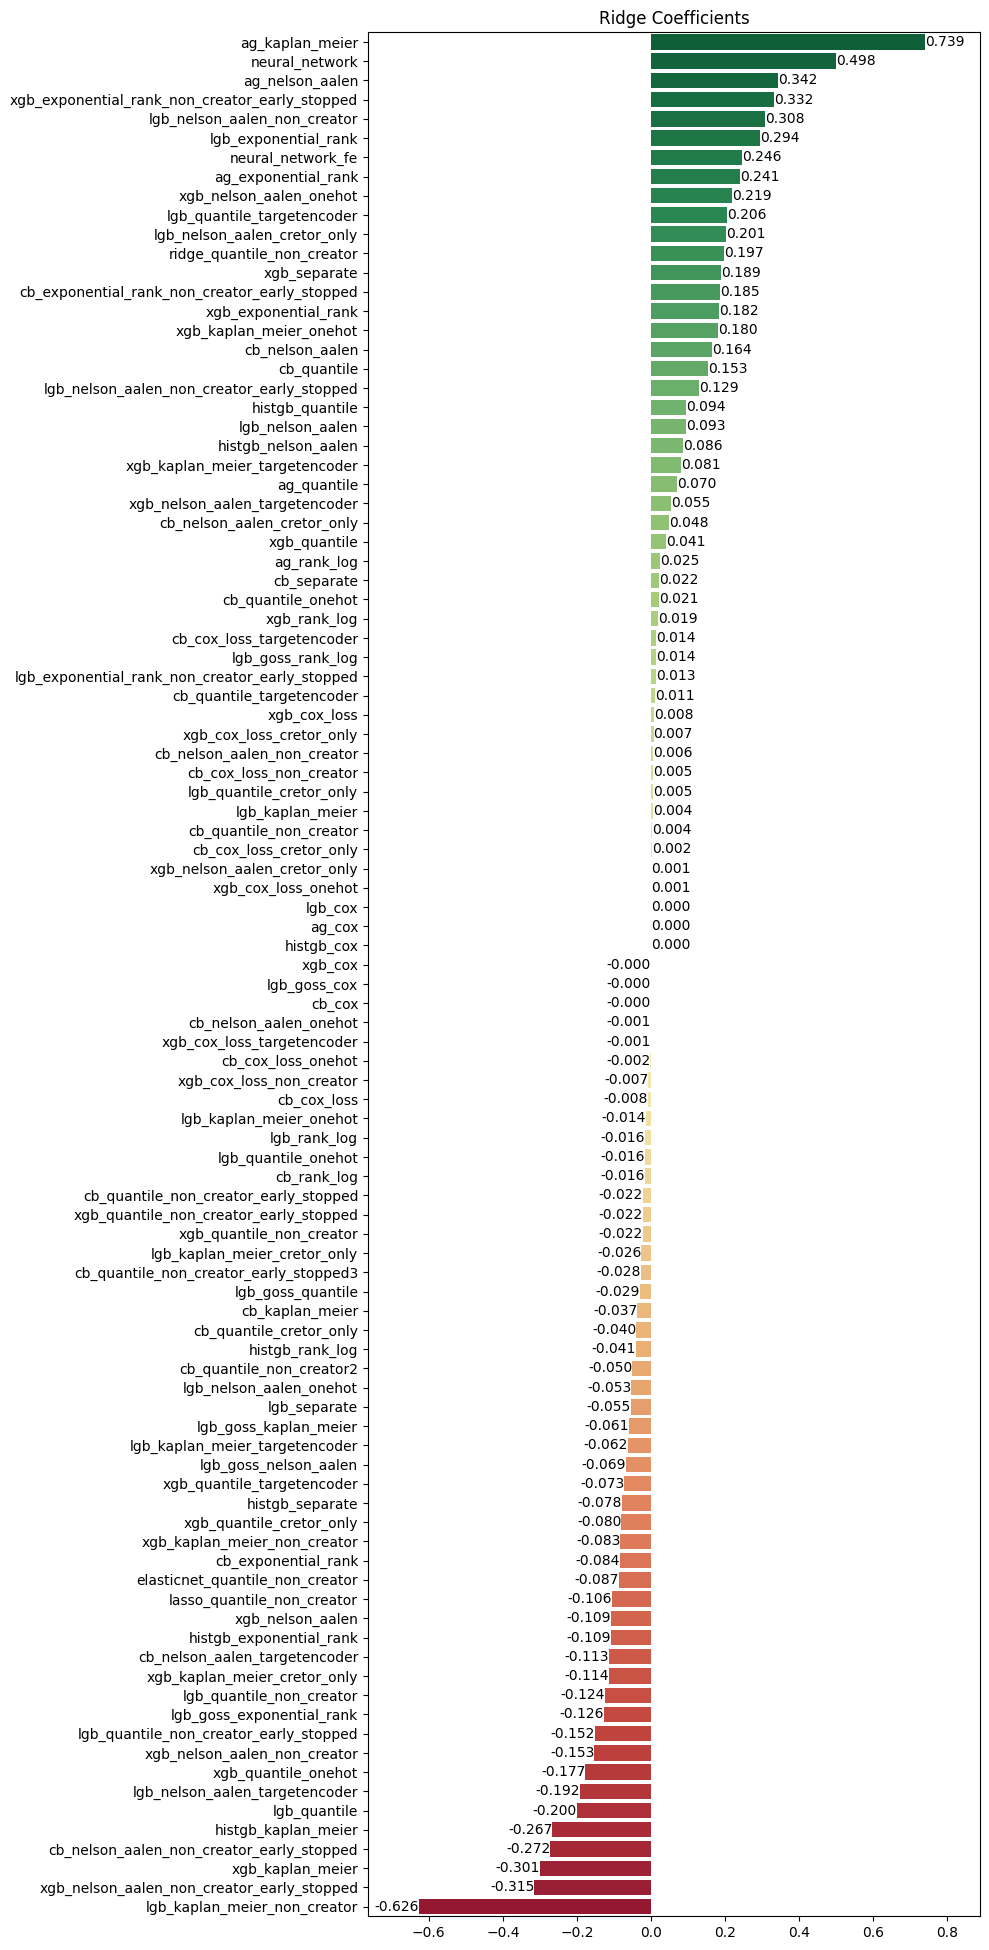

In [56]:
plot_weights(ensemble_X.columns.tolist(), coeffs, "Ridge Coefficients")

## Feature selection

In [57]:
sorted_scores = {k: v for k, v in sorted(overall_scores.items(), key=lambda item: item[1], reverse=False)}
all_features = [k for k in sorted_scores.keys() if k in oof_preds.keys()]

if CFG.run_feature_selection:
    
    removed_features = []
    
    best_score = overall_scores["ensemble"]
    print(f"Baseline CI Score: {best_score:.6f} | Feature Count: {len(all_features)}\n")
    
    for i, feature in enumerate(all_features):
        reduced_features = all_features.copy()
        reduced_features.remove(feature)
        reduced_features = [f for f in reduced_features if f not in removed_features]
        
        X_reduced = ensemble_X[reduced_features]
        
        ensemble_model = Ridge(random_state=CFG.seed)
        ensemble_trainer = EnsembleTrainer(ensemble_model, "quantile", CFG)
        temp_score = ensemble_trainer.tune(X_reduced, y)
        
        if temp_score > best_score:
            best_score = temp_score
            removed_features.append(feature)
            print(f"{i+1}/{len(all_features)} CI Score: {temp_score:.6f} | Feature Count: {len(reduced_features)} | {feature} (New Best Score!)")
        else:
            print(f"{i+1}/{len(all_features)} CI Score: {temp_score:.6f} | Feature Count: {len(reduced_features)} | {feature}")
            
        del X_reduced, ensemble_model, ensemble_trainer
        gc.collect()
else:
    removed_features = [
        'lasso_quantile_non_creator', 'histgb_separate', 'lgb_separate', 'cb_separate', 'xgb_cox_loss_cretor_only', 'cb_cox_loss_cretor_only',
        'cb_cox_loss_targetencoder', 'cb_cox_loss_onehot', 'histgb_cox', 'cb_nelson_aalen_cretor_only', 'xgb_kaplan_meier_cretor_only',
        'lgb_kaplan_meier_onehot', 'histgb_kaplan_meier', 'lgb_kaplan_meier_targetencoder', 'cb_nelson_aalen_onehot', 'lgb_goss_kaplan_meier',
        'lgb_kaplan_meier_cretor_only', 'cb_cox_loss_non_creator', 'lgb_cox', 'xgb_kaplan_meier', 'cb_nelson_aalen_targetencoder',
        'xgb_nelson_aalen_cretor_only', 'xgb_cox', 'xgb_kaplan_meier_non_creator', 'lgb_goss_nelson_aalen', 'xgb_cox_loss', 
        'xgb_nelson_aalen_targetencoder', 'cb_quantile_cretor_only', 'histgb_nelson_aalen', 'lgb_nelson_aalen_onehot', 'cb_quantile_onehot',
        'lgb_rank_log', 'cb_kaplan_meier', 'cb_quantile_targetencoder', 'cb_cox_loss', 'xgb_rank_log', 'lgb_goss_quantile', 'lgb_quantile_onehot',
        'cb_rank_log', 'xgb_quantile_targetencoder', 'histgb_exponential_rank', 'cb_nelson_aalen_non_creator', 'lgb_nelson_aalen', 
        'lgb_quantile_cretor_only', 'lgb_nelson_aalen_non_creator', 'xgb_nelson_aalen_non_creator', 'cb_nelson_aalen_non_creator_early_stopped',
        'lgb_nelson_aalen_non_creator_early_stopped', 'cb_quantile_non_creator_early_stopped', 'cb_nelson_aalen', 'cb_quantile_non_creator', 
        'cb_quantile_non_creator_early_stopped3', 'xgb_quantile', 'cb_quantile_non_creator2', 'lgb_quantile_non_creator', 'xgb_quantile_non_creator',
        'lgb_quantile_non_creator_early_stopped', 'lgb_exponential_rank_non_creator_early_stopped', 'cb_exponential_rank', 'ag_nelson_aalen',
        'ag_quantile', 'ag_exponential_rank'
    ]

In [58]:
selected_features = [f for f in all_features if f not in removed_features]
print(selected_features)

['ridge_quantile_non_creator', 'elasticnet_quantile_non_creator', 'xgb_separate', 'xgb_cox_loss_targetencoder', 'lgb_goss_cox', 'histgb_rank_log', 'xgb_kaplan_meier_onehot', 'xgb_cox_loss_onehot', 'xgb_kaplan_meier_targetencoder', 'cb_cox', 'xgb_quantile_cretor_only', 'lgb_kaplan_meier_non_creator', 'lgb_kaplan_meier', 'xgb_nelson_aalen_onehot', 'lgb_goss_rank_log', 'xgb_cox_loss_non_creator', 'xgb_quantile_onehot', 'lgb_nelson_aalen_targetencoder', 'histgb_quantile', 'lgb_nelson_aalen_cretor_only', 'xgb_nelson_aalen', 'lgb_goss_exponential_rank', 'lgb_quantile_targetencoder', 'xgb_nelson_aalen_non_creator_early_stopped', 'ag_kaplan_meier', 'lgb_quantile', 'ag_cox', 'xgb_quantile_non_creator_early_stopped', 'xgb_exponential_rank', 'ag_rank_log', 'lgb_exponential_rank', 'xgb_exponential_rank_non_creator_early_stopped', 'cb_exponential_rank_non_creator_early_stopped', 'cb_quantile', 'neural_network_fe', 'neural_network']


In [59]:
print(removed_features)

['lasso_quantile_non_creator', 'histgb_separate', 'lgb_separate', 'cb_separate', 'xgb_cox_loss_cretor_only', 'cb_cox_loss_cretor_only', 'cb_cox_loss_targetencoder', 'cb_cox_loss_onehot', 'histgb_cox', 'cb_nelson_aalen_cretor_only', 'xgb_kaplan_meier_cretor_only', 'lgb_kaplan_meier_onehot', 'histgb_kaplan_meier', 'lgb_kaplan_meier_targetencoder', 'cb_nelson_aalen_onehot', 'lgb_goss_kaplan_meier', 'lgb_kaplan_meier_cretor_only', 'cb_cox_loss_non_creator', 'lgb_cox', 'xgb_kaplan_meier', 'cb_nelson_aalen_targetencoder', 'xgb_nelson_aalen_cretor_only', 'xgb_cox', 'xgb_kaplan_meier_non_creator', 'lgb_goss_nelson_aalen', 'xgb_cox_loss', 'xgb_nelson_aalen_targetencoder', 'cb_quantile_cretor_only', 'histgb_nelson_aalen', 'lgb_nelson_aalen_onehot', 'cb_quantile_onehot', 'lgb_rank_log', 'cb_kaplan_meier', 'cb_quantile_targetencoder', 'cb_cox_loss', 'xgb_rank_log', 'lgb_goss_quantile', 'lgb_quantile_onehot', 'cb_rank_log', 'xgb_quantile_targetencoder', 'histgb_exponential_rank', 'cb_nelson_aalen_n

## Reduced features

In [60]:
ensemble_X = pd.DataFrame(oof_preds)[selected_features]
ensemble_X_test = pd.DataFrame(test_preds)[selected_features]

In [61]:
def objective(trial):    
    params = {
        'random_state': CFG.seed,
        'alpha': trial.suggest_float('alpha', 1e-7, 1),
        'tol': trial.suggest_float('tol', 1e-5, 1e-2),
        'positive': trial.suggest_categorical('positive', [True, False]),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False])
    }
    
    ensemble_model = Ridge(**params)
    ensemble_trainer = EnsembleTrainer(ensemble_model, "quantile", CFG)
    return ensemble_trainer.tune(ensemble_X, y)


if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True, n_startup_trials=CFG.optuna_warmup_trials)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.optuna_trials, n_jobs=-1)
    best_params = study.best_params
    
    ensemble_params = {
        "random_state": CFG.seed,
        "alpha": best_params["alpha"],
        "tol": best_params["tol"]
    }
else:
    ensemble_params = {
        'alpha': 0.009857523310720196, 
        'tol': 0.00407307016988211,
        'positive': False,
        'fit_intercept': False
    }

In [62]:
print(json.dumps(ensemble_params, indent=2))

{
  "alpha": 0.009857523310720196,
  "tol": 0.00407307016988211,
  "positive": false,
  "fit_intercept": false
}


In [63]:
ensemble_model = Ridge(**ensemble_params)
ensemble_trainer = EnsembleTrainer(ensemble_model, "quantile", CFG)

ensemble_reduced_test_preds, coeffs, scores["ensemble_reduced"], overall_scores["ensemble_reduced"] = ensemble_trainer.fit_predict(ensemble_X, y, ensemble_X_test)

Training ensembler with target transformation: quantile

--- Fold 1 - CI: 0.679251
--- Fold 2 - CI: 0.683039
--- Fold 3 - CI: 0.685890
--- Fold 4 - CI: 0.679304
--- Fold 5 - CI: 0.677706
--- Fold 6 - CI: 0.687652
--- Fold 7 - CI: 0.675716
--- Fold 8 - CI: 0.673447
--- Fold 9 - CI: 0.673389
--- Fold 10 - CI: 0.677362

------ Overall CI: 0.687408



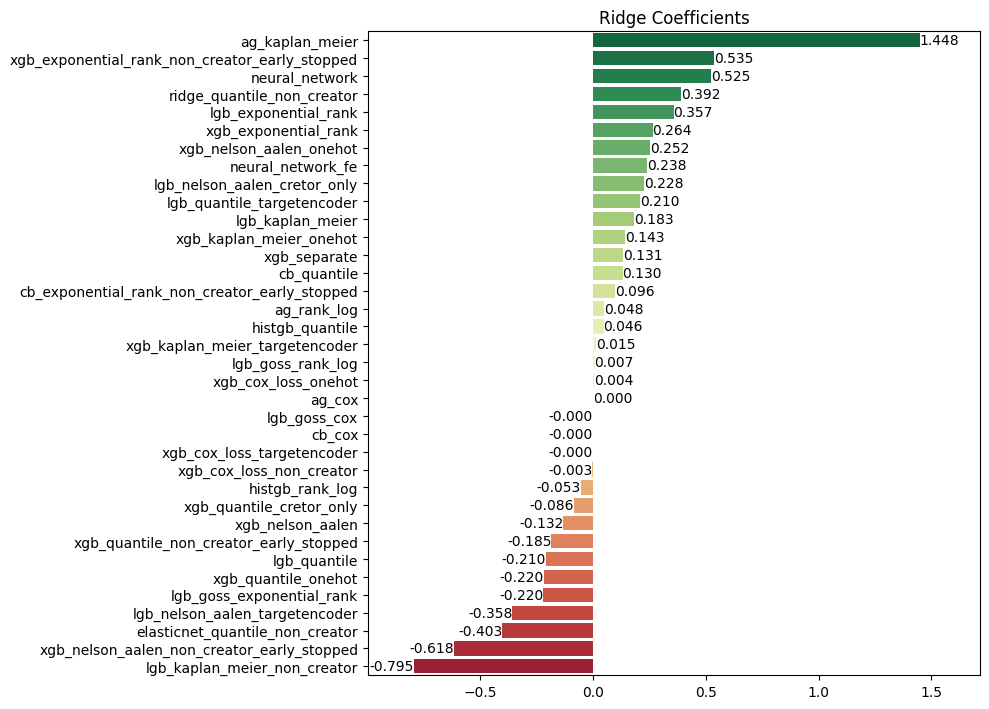

In [64]:
plot_weights(ensemble_X.columns.tolist(), coeffs, "Ridge Coefficients")

# Results

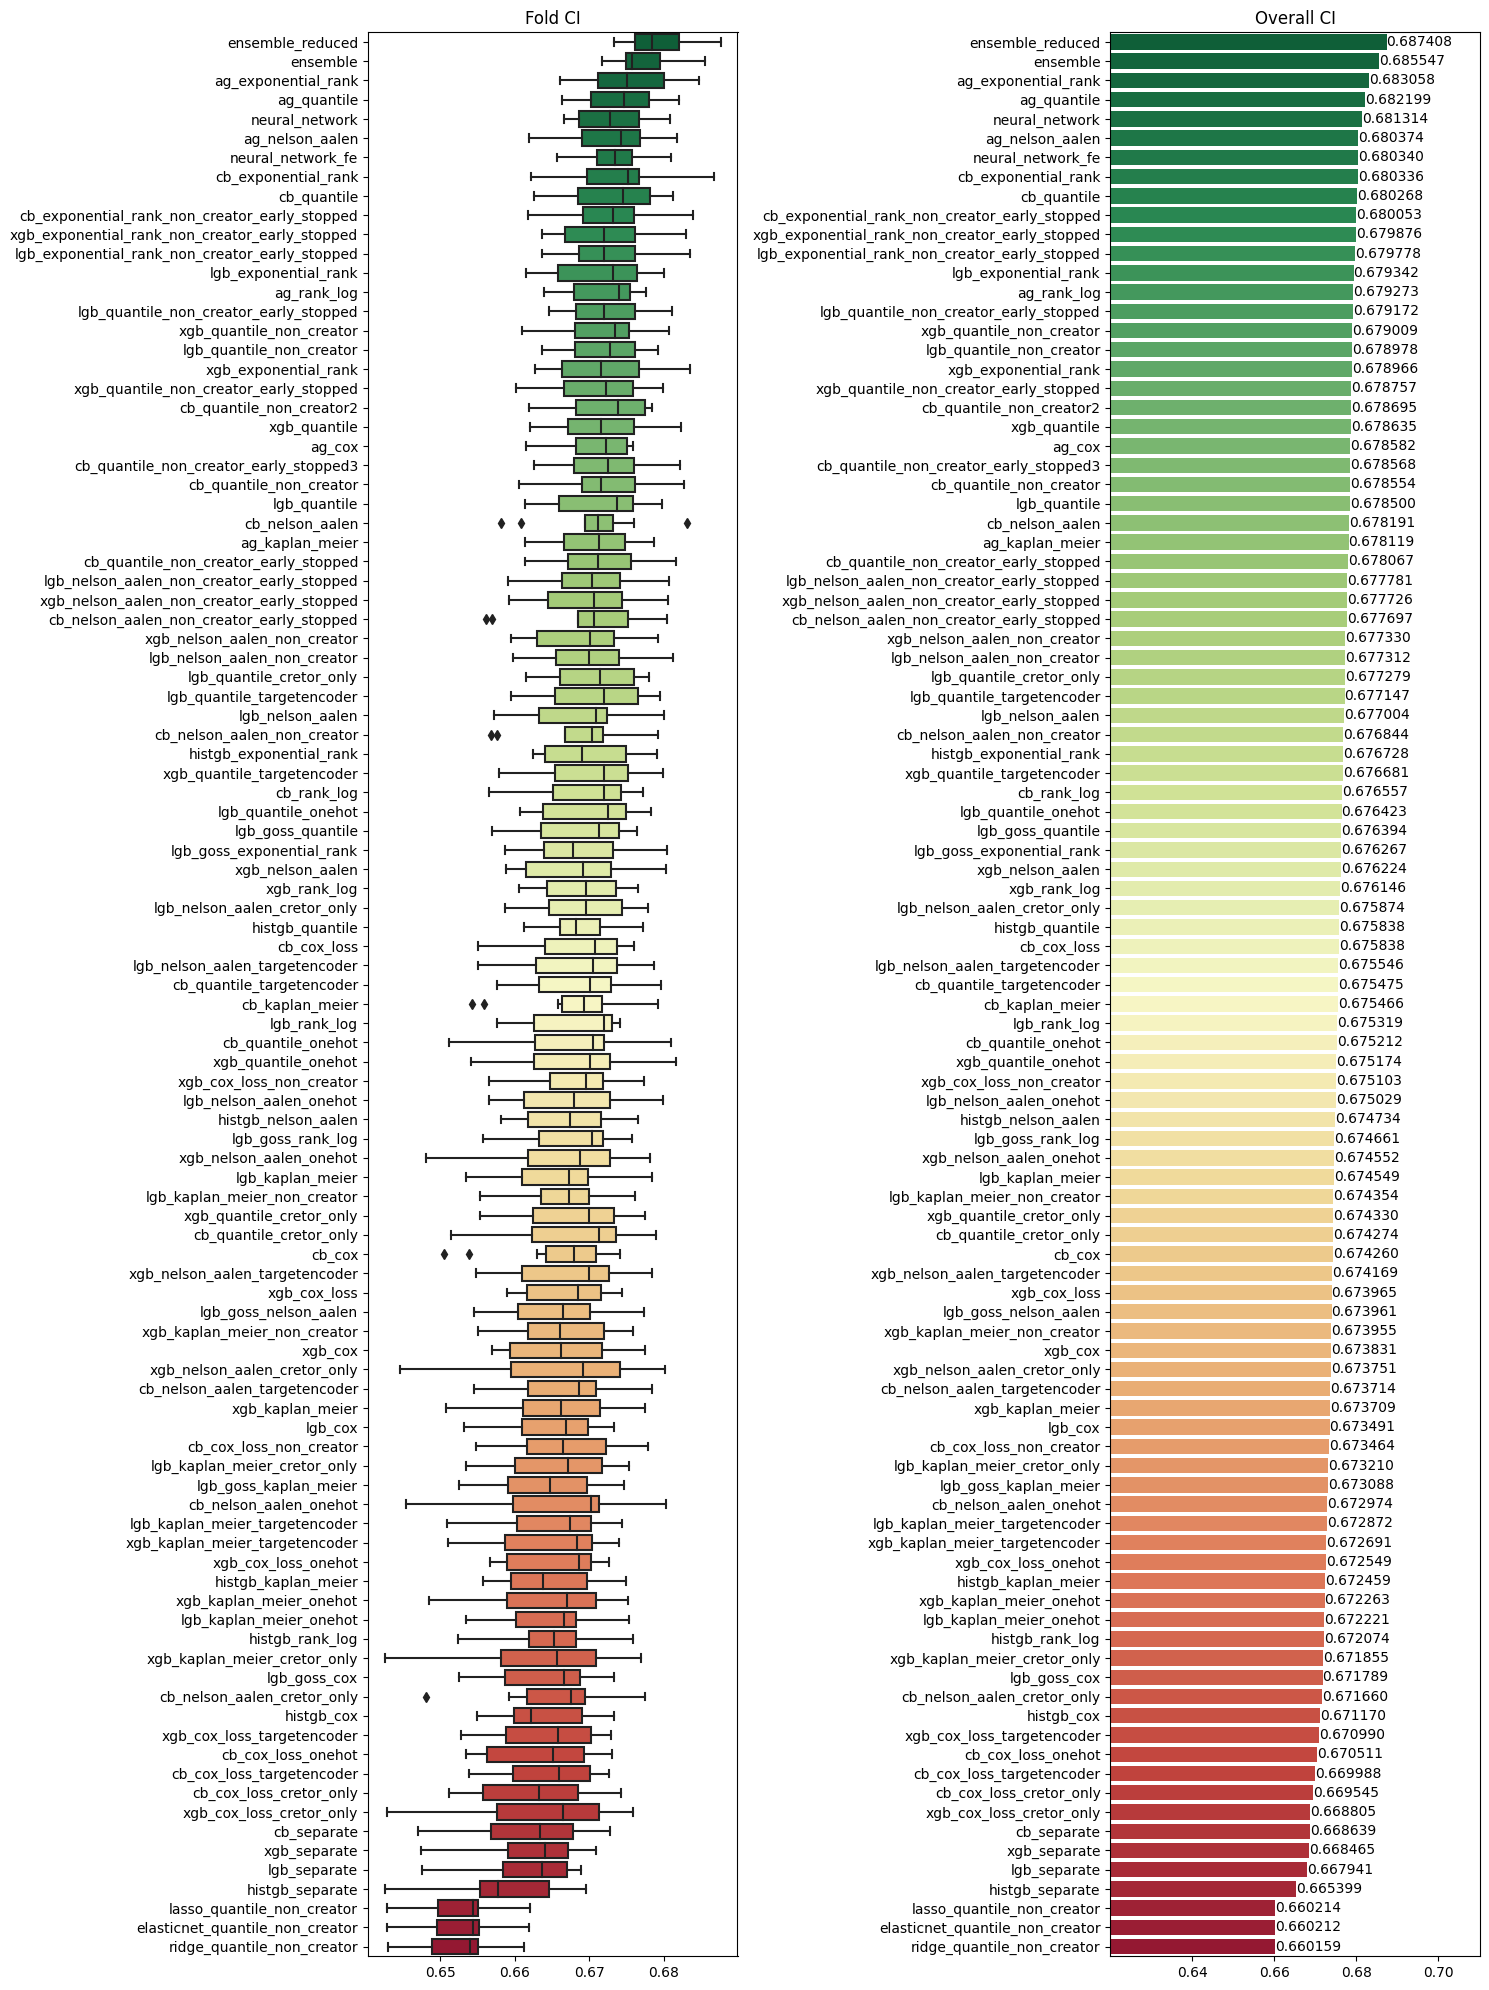

In [65]:
scores_df = pd.DataFrame(scores)
overall_scores_series = pd.Series({k: v for k, v in overall_scores.items()})
order = overall_scores_series.sort_values(ascending=False).index.tolist()

min_score = min(scores_df.min().min(), overall_scores_series.min())
max_score = max(scores_df.max().max(), overall_scores_series.max())
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, len(scores) * 0.2))

sns.boxplot(data=scores_df, order=order, ax=axs[0], orient="h", palette="RdYlGn_r")
axs[0].set_title("Fold CI")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=overall_scores_series, y=overall_scores_series.index, ax=axs[1], palette="RdYlGn_r", order=order)
axs[1].set_title("Overall CI")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, _score in enumerate(overall_scores_series[order]):
    barplot.text(_score, i, f"{_score:.6f}", va="center")

plt.tight_layout()
plt.show()

# Creating a submission file

In [66]:
sub = pd.read_csv(CFG.sample_sub_path)
sub.prediction = ensemble_reduced_test_preds
sub.to_csv("submission.csv", index=False)
sub.head()

,ID,prediction
0,28800,2.2
1,28801,2.8
2,28802,1.0


In [67]:
shutil.rmtree("lightning_logs", ignore_errors=True)